In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [3]:
# For implementing cylindrical coordinates
solver1D_from = lambda i: readwritedatafiles.read_data_file(
  f"tung_conduit1_{i}.pkl")
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung_atm{j}_{i}.pkl")

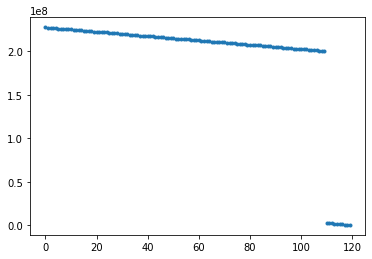

In [153]:
solver_ = readwritedatafiles.read_data_file(
  f"tung2_conduit1_0.pkl")
plt.plot(solver_.physics.compute_variable("Pressure", solver_.state_coeffs).ravel(), '.')

In [187]:
# Grab 0 state
p_hydro = [mdtools.downsample(solver2D_from(0, j+1), plot_qty="Pressure")[1] for j in range(5)]

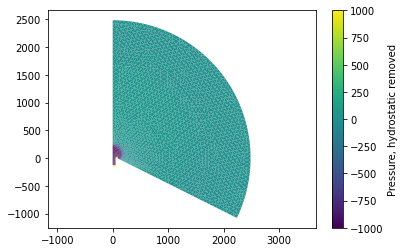

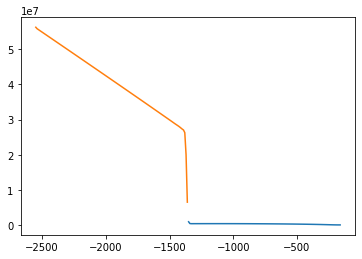

In [207]:
solver1D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung2_conduit{j}_{i}.pkl")

for i in range(20):
  plt.figure(1)
  plt.clf()
  for j in range(3):
    x1, v = mdtools.downsample(solver2D_from(i, j+1), plot_qty="Pressure")
    clims = (-1e3,1e3)
    mdtools.plot_mean(x1, v-p_hydro[j], clims)

  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  cb.set_label("Pressure, hydrostatic removed")
  plt.savefig(f"out2D_{i}.png")

  plt.figure(2)
  plt.clf()
  for j in [1,2]:
    x1, v = mdtools.downsample(solver1D_from(i, j), plot_qty="Pressure")
    plt.plot(x1[:,0,:].squeeze(), v[:,0,:].squeeze())
  plt.savefig(f"out1D_{i}.png")
  

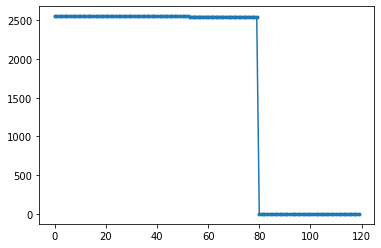

In [375]:
# plt.plot(solver1D_from(0,1).state_coeffs[:,:,0].ravel(), '.-')
# plt.plot(solver1D_from(0,1).state_coeffs[:,:,1].ravel(), '.-')
plt.plot(solver1D_from(0,1).state_coeffs[:,:,2].ravel(), '.-')

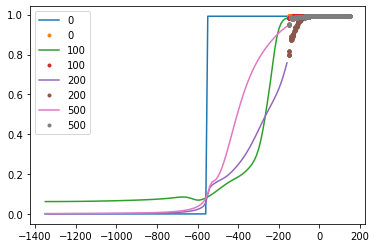

In [398]:
''' Plot pressure along axis (across 1D, 2D) '''
solver1D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_conduit{j}_{i}.pkl")
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_atm{j}_{i}.pkl")
for i in [0,100,200,500]:
  for j in [1]:
    x1, v = mdtools.downsample(solver1D_from(i, j), plot_qty="volFracA")
    plt.plot(x1[:,0,:].squeeze(), v[:,0,:].squeeze())

  x2d, v2d = mdtools.downsample(solver2D_from(i,1), plot_qty="volFracA")
  y2d = x2d[:,:,-1].ravel()
  x2d = x2d[:,:,0].ravel()
  plt.plot(y2d[np.logical_and(x2d < 100, y2d < 150)], v2d.ravel()[np.logical_and(x2d < 100, y2d < 150)], '.')
plt.legend([0,0,100,100,200,200,500,500])

In [495]:
# Volume flow rate
volflow = []
massflow = []
t_volflow = []
t_wavetravel_array = []
for i in range(150):
  s = solver1D_from(i*5, 1) # Faster index for solver1D ******
  volflow.append(np.pi * 50**2 * 
      s.state_coeffs[-1,-1,3] / np.sum(s.state_coeffs[-1,-1,0:3])
  )
  massflow.append(
    np.pi * 50**2 * 
      s.state_coeffs[-1,-1,3]
  )
  t_volflow.append(s.time)
  # Compute average sound speed
  c1 = s.physics.compute_variable("SoundSpeed", s.state_coeffs[:,:,:]).squeeze()
  s2 = solver1D_from(i, 2)
  c2 = s2.physics.compute_variable("SoundSpeed", s2.state_coeffs[:,:,:]).squeeze()
  import scipy.stats
  meanspeed = scipy.stats.hmean(np.concatenate((c1, c2)))
  L = s.mesh.node_coords.max() - s2.mesh.node_coords.min()
  t_wavetravel = L / meanspeed
  t_wavetravel_array.append(t_wavetravel)
  
volflow = np.array(volflow)
massflow = np.array(massflow)
t_volflow = np.array(t_volflow)
t_wavetravel_array = np.array(t_wavetravel_array)

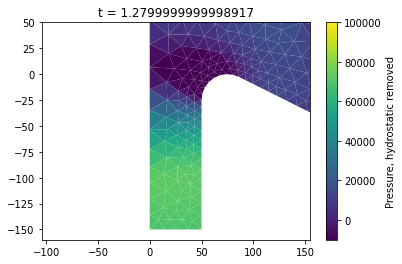

In [496]:
# Near-vent plot
i = 16

for j in range(1):
  s = solver2D_from(i, j+1)
  x1, v = mdtools.downsample(s, plot_qty="Pressure")
  clims = (-1e4,1e5)
  mdtools.plot_mean(x1, v-p_hydro[j], clims)
  plt.title(f"t = {s.time}")
# mdtools.plot_mean(x1, v-p_hydro[j], clims)
plt.xlim((0, 50))
plt.ylim((-160,50))

sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
cb.set_label("Pressure, hydrostatic removed")

750.0966467739896

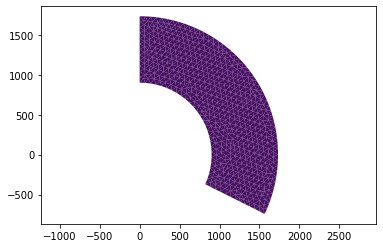

In [497]:
mdtools.plot_mean(x, s.physics.compute_variable("SoundSpeed", solver2D_from(10,1).state_coeffs) \
  * np.sum(solver2D_from(10,1).state_coeffs[...,0:3], axis=-1, keepdims=True), (0, 10000))
(s.physics.compute_variable("SoundSpeed", solver2D_from(10,1).state_coeffs) \
  * np.sum(solver2D_from(10,1).state_coeffs[...,0:3], axis=-1, keepdims=True)).max()

C:\Users\Fredric\Documents\Volcano\quail_volcano\src\physics\multiphasevpT\multiphasevpT.py:269: RuntimeWarning: invalid value encountered in sqrt
  varq = np.sqrt(get_Gamma()*get_pressure()/(arhoA+arhoWv+arhoM)*get_Psi1())


Done


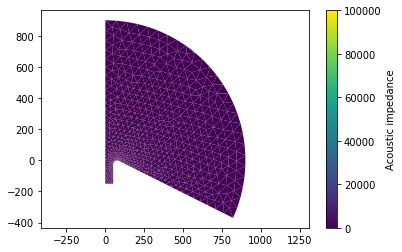

In [498]:
# (Import) Plot volfrac density
import matplotlib.animation as animation

outfilename = "tung3_imped2"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(), f"{outfilename}.mp4")

# plot_idx = 20

for plot_idx in [i+1 for i in range(0,750,10)]:
  plt.clf()
  clims = (0,1e5)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    rho = np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True)
    yM = solver.state_coeffs[:,:,2:3] / rho
    Z = solver.physics.compute_variable("SoundSpeed", solver.state_coeffs) \
      * np.sum(solver.state_coeffs[...,0:3], axis=-1, keepdims=True)
    mdtools.plot_mean(x, Z, clims)

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("Acoustic impedance")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

Done


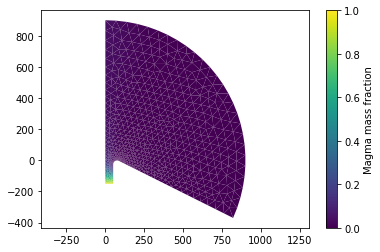

In [403]:
# (Import) Plot volfrac density
import matplotlib.animation as animation

outfilename = "tung3_yM"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(), f"{outfilename}.mp4")

# plot_idx = 20
fig = plt.figure(figsize=(8, 6), dpi=160)

for plot_idx in [i+1 for i in range(0,750,10)]:
  plt.clf()
  clims = (0,1)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    rho = np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True)
    yM = solver.state_coeffs[:,:,2:3] / rho
    mdtools.plot_mean(x, yM, clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("Magma mass fraction")

  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

Done


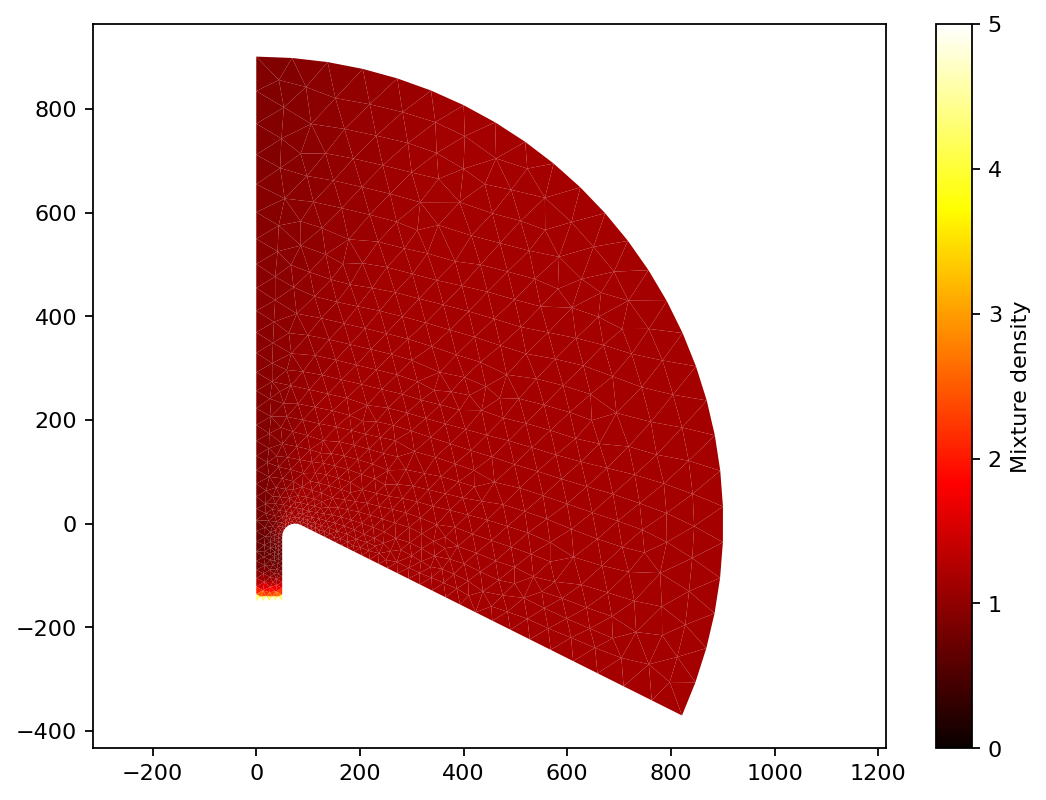

In [2067]:
# (Import) Plot total density
import matplotlib.animation as animation

outfilename = "tung3_new_mixdensity"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(figsize=(8, 6), dpi=160), f"{outfilename}.mp4")


for plot_idx in [i+1 for i in range(0,750,10)]:
  plt.clf()
  clims = (0,5)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    mdtools.plot_mean(x,
      np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True), clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("Mixture density")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

KeyboardInterrupt: 

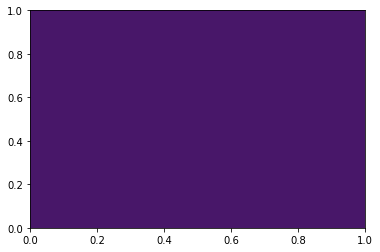

In [510]:
# (Import) Plot |grad rho|
import matplotlib.animation as animation

outfilename = "tung3_schlieren"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(), f"{outfilename}.mp4")

# plot_idx = 20
# fig = plt.figure(figsize=(8, 6), dpi=160)

for plot_idx in [i+1 for i in range(750)]:
  plt.clf()
  clims = (0,.01)

  domain_indices = [1]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    sample_basis_phys_grad_elems = []
    sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
    for elem_ID in range(solver.mesh.num_elems):
      solver.basis.get_basis_val_grads(
              sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
              get_val=True,
              get_ref_grad=True,
              get_phys_grad=True,
              ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
      sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
    # du_ij = np.einsum('ijnl, ink -> ijkl',
    #       np.array(sample_basis_phys_grad_elems),
    #       solver.physics.compute_variable("Pressure", solver.state_coeffs))
    normgradp = np.linalg.norm(
      np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True)),
      axis=2, keepdims=True)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    mdtools.plot_mean(x, normgradp, clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("$|\\nabla rho|$")
  plt.title(f"Time: {solver.time:.2f} s")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

In [2038]:
solver1D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_conduit{j}_{i}.pkl")

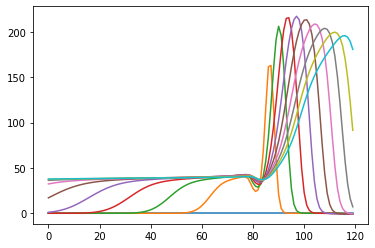

In [2065]:
get_p = lambda U: solver1D_from(i,1).physics.compute_variable("phi", U)

for i in range(10):
  # plt.plot(get_p(solver1D_from(i,1).state_coeffs[:,:,:]).ravel())
  plt.plot(solver1D_from(i,1).state_coeffs[:,:,3] / solver1D_from(i,1).state_coeffs[:,:,0:3].sum(axis=-1))

In [2059]:
p.min()

88072.90550957787

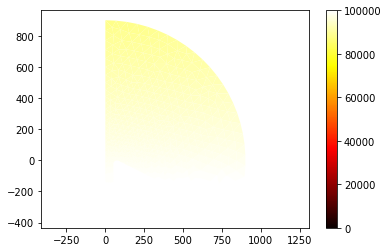

In [2057]:
plt.figure()
plt.set_cmap("hot")
p = physics.compute_variable("Pressure", solver2D_from(10,1).state_coeffs)
x, p = mdtools.downsample( solver2D_from(1,1))
clims=(0,1e5)
mdtools.plot_mean(x,p,clims)
mdtools.set_cbar(clims)


In [2035]:
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_atm{j}_{i}.pkl")

In [2091]:
plt.set_cmap("summer")

<Figure size 432x288 with 0 Axes>

In [2099]:
gradp = np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        np.sum(solver2D_from(0,1).state_coeffs[:,:,0:3],axis=2,keepdims=True))
# gradp[...,1] += rho0 * 9.8
normgradp = np.linalg.norm(
  gradp,
  axis=2, keepdims=True)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (1584,3,3,2)->(1584,3,newaxis,2,3) (1215,3,1)->(1215,newaxis,1,newaxis,3) 

In [ ]:
mdtools.viz(solver2D_from(20,1), plot_qty:str="Pressure", levels=None, clims=None):

In [2105]:
%matplotlib tk
plt.set_cmap("viridis")

In [2141]:
# Default font size
plt.rcParams['font.size'] = 10.0

10.0

In [2208]:
%matplotlib tk
# (Import) Plot |grad p|
import matplotlib.animation as animation

solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_atm{j}_{i}.pkl")
solver1D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_conduit{j}_{i}.pkl")

default, plt.rcParams['font.size'] = plt.rcParams['font.size'], 12

outfilename = "tung3_pressuregrad_newALL_longwithIC_"
fig = plt.figure(figsize=(11, 6), dpi=140)
FFwriter = animation.FFMpegWriter()
FFwriter.setup(fig, f"{outfilename}.mp4")

def diff1D_p0(x1D, U1D):
  ''' 1D differentiation for p0 elements. Standard 2n '''
  U_bar1D = U1D.mean(axis=1, keepdims=True)
  dx1D = (x1D[:,-1:,:] - x1D[:,0:1,:])
  # Centered differencing
  dUdx = 0.5 * (np.roll(U_bar1D, -1, axis=0) - np.roll(U_bar1D, 1, axis=0)) \
    / (x1D[:,-1:,:] - x1D[:,0:1,:])
  # Boundary one-sided difference
  dUdx[0,...] = (U_bar1D[1,...] - U_bar1D[0,...]) / (x1D[1,-1:,:] - x1D[0,0:1,:])
  dUdx[-1,...] = (U_bar1D[-1,...] - U_bar1D[-2,...]) / (x1D[-1,-1:,:] - x1D[-2,0:1,:])
  return dUdx

pgrads_grav_init1D = [
  9.8 * solver1D_from(0,1).state_coeffs[...,0:3].sum(axis=-1, keepdims=True),
  9.8 * solver1D_from(0,2).state_coeffs[...,0:3].sum(axis=-1, keepdims=True)]

# plot_idx = 20
plt.set_cmap("viridis")

grad_filter = lambda x: np.log10(np.abs(x))

for plot_idx in [i for i in range(0,151,1)]:
  plt.clf()
  clims = (-0.5,2.2)
  clims_T = (300,800)

  domain_indices = [1,2,3]
  for dom_idx in domain_indices:
    if dom_idx == 1:
      solver = solver2D_from(5*plot_idx, dom_idx)
    elif dom_idx == 2:
      solver = solver2D_from(plot_idx, dom_idx)
    elif dom_idx == 3:
      solver = solver2D_from(10*plot_idx, dom_idx)
    else:
        raise Exception
    sample_basis_phys_grad_elems = []
    sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
    for elem_ID in range(solver.mesh.num_elems):
      solver.basis.get_basis_val_grads(
              sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
              get_val=True,
              get_ref_grad=True,
              get_phys_grad=True,
              ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
      sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
    # du_ij = np.einsum('ijnl, ink -> ijkl',
          # np.array(sample_basis_phys_grad_elems),
          # solver.physics.compute_variable("Pressure", solver.state_coeffs))
    p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
    gradp = np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        p)
    gradp[...,1] += rho0 * 9.8
    normgradp = np.linalg.norm(
      gradp,
      axis=2, keepdims=True)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, normgradp, solver, levels=None)
    mdtools.plot_mean(x, grad_filter(normgradp), clims)#(0,25))
    x_symm = x.copy()
    x_symm[...,0] *= -1
    T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
    plt.set_cmap("magma")
    mdtools.plot_mean(x_symm, T, clims_T)
    plt.set_cmap("viridis")

  # Add 1D components
  for dom_idx in [1,2]:
    if dom_idx == 1:
      solver1D = solver1D_from(5*plot_idx,dom_idx)
      hydrograd = pgrads_grav_init1D[0]
    elif dom_idx == 2:
      solver1D = solver1D_from(plot_idx,dom_idx)
      hydrograd = pgrads_grav_init1D[1]
    
    x1D, p1D = mdtools.downsample(solver1D, "Pressure")
    _, T1D = mdtools.downsample(solver1D, "Temperature")
    gradp1D = diff1D_p0(x1D, p1D)
    # Compute pressure gradient subtracting initial hydrostatic
    plt.set_cmap("viridis")
    mdtools.plot_mean1D(x1D, grad_filter(gradp1D + hydrograd), clims, xscale=50.0)
    plt.set_cmap("magma")
    mdtools.plot_mean1D(x1D, T1D, clims_T, xscale=50.0, xshift=-50.0)
    plt.set_cmap("viridis")

  # plt.xlim((0,100))
  # plt.ylim((-1000,-150))

  plt.set_cmap("viridis")
  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.ax.set_title("$\mathrm{log}_{10} |\\nabla p - \\rho_0 g|$ (Pa/m)")
  plt.set_cmap("magma")
  cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims_T[0], vmax=clims_T[1]),
      cmap=plt.get_cmap()), location="left", pad=0.18)
  cb.ax.set_title("$T$ (K)")
  plt.set_cmap("viridis")

  # plt.show()
  # plt.pause(0.05)
  plt.ylim((-2000,2500))
  plt.xlabel("$x$ (m)")
  plt.ylabel("$y$ (m)")
  plt.title(f"$t = {solver.time:.2f}$ s")

  FFwriter.grab_frame()
  print(plot_idx)

FFwriter.finish()
print("Done")

plt.rcParams['font.size'] = default

C:\Users\Fredric\AppData\Local\Temp\ipykernel_32104\1479878167.py:36: RuntimeWarning: divide by zero encountered in log10
  grad_filter = lambda x: np.log10(np.abs(x))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Done


In [2237]:
''' Figure: initial setup. Plots still of domain at t = 0. '''

%matplotlib tk
# (Import) Plot |grad p|
import matplotlib.animation as animation

solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_atm{j}_{i}.pkl")
solver1D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_conduit{j}_{i}.pkl")

default, plt.rcParams['font.size'] = plt.rcParams['font.size'], 12

fig = plt.figure(figsize=(11, 6), dpi=140)

def diff1D_p0(x1D, U1D):
  ''' 1D differentiation for p0 elements. Standard 2n '''
  U_bar1D = U1D.mean(axis=1, keepdims=True)
  dx1D = (x1D[:,-1:,:] - x1D[:,0:1,:])
  # Centered differencing
  dUdx = 0.5 * (np.roll(U_bar1D, -1, axis=0) - np.roll(U_bar1D, 1, axis=0)) \
    / (x1D[:,-1:,:] - x1D[:,0:1,:])
  # Boundary one-sided difference
  dUdx[0,...] = (U_bar1D[1,...] - U_bar1D[0,...]) / (x1D[1,-1:,:] - x1D[0,0:1,:])
  dUdx[-1,...] = (U_bar1D[-1,...] - U_bar1D[-2,...]) / (x1D[-1,-1:,:] - x1D[-2,0:1,:])
  return dUdx

pgrads_grav_init1D = [
  9.8 * solver1D_from(0,1).state_coeffs[...,0:3].sum(axis=-1, keepdims=True),
  9.8 * solver1D_from(0,2).state_coeffs[...,0:3].sum(axis=-1, keepdims=True)]

# plot_idx = 20
plt.set_cmap("viridis")

grad_filter = lambda x: np.log10(np.abs(x))

for plot_idx in [0]:
  plt.clf()
  clims = (-0.5,2.2)
  clims_T = (300,800)

  domain_indices = [1,2,3]
  for dom_idx in domain_indices:
    if dom_idx == 1:
      solver = solver2D_from(5*plot_idx, dom_idx)
    elif dom_idx == 2:
      solver = solver2D_from(plot_idx, dom_idx)
    elif dom_idx == 3:
      solver = solver2D_from(10*plot_idx, dom_idx)
    else:
        raise Exception
    sample_basis_phys_grad_elems = []
    sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
    for elem_ID in range(solver.mesh.num_elems):
      solver.basis.get_basis_val_grads(
              sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
              get_val=True,
              get_ref_grad=True,
              get_phys_grad=True,
              ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
      sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
    # du_ij = np.einsum('ijnl, ink -> ijkl',
          # np.array(sample_basis_phys_grad_elems),
          # solver.physics.compute_variable("Pressure", solver.state_coeffs))
    p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
    gradp = np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        p)
    gradp[...,1] += rho0 * 9.8
    normgradp = np.linalg.norm(
      gradp,
      axis=2, keepdims=True)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, normgradp, solver, levels=None)
    mdtools.plot_mean(x, grad_filter(normgradp), clims)#(0,25))
    x_symm = x.copy()
    x_symm[...,0] *= -1
    T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
    plt.set_cmap("magma")
    mdtools.plot_mean(x_symm, T, clims_T)
    plt.set_cmap("viridis")

  # Add 1D components
  for dom_idx in [1,2]:
    if dom_idx == 1:
      solver1D = solver1D_from(5*plot_idx,dom_idx)
      hydrograd = pgrads_grav_init1D[0]
    elif dom_idx == 2:
      solver1D = solver1D_from(plot_idx,dom_idx)
      hydrograd = pgrads_grav_init1D[1]
    
    x1D, p1D = mdtools.downsample(solver1D, "Pressure")
    _, T1D = mdtools.downsample(solver1D, "Temperature")
    gradp1D = diff1D_p0(x1D, p1D)
    # Compute pressure gradient subtracting initial hydrostatic
    plt.set_cmap("viridis")
    mdtools.plot_mean1D(x1D, grad_filter(gradp1D + hydrograd), clims, xscale=50.0)
    plt.set_cmap("magma")
    mdtools.plot_mean1D(x1D, T1D, clims_T, xscale=50.0, xshift=-50.0)
    plt.set_cmap("viridis")

  # plt.xlim((0,100))
  # plt.ylim((-1000,-150))

  plt.set_cmap("viridis")
  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.ax.set_title("$\mathrm{log}_{10} |\\nabla p - \\rho_0 g|$ (Pa/m)")
  plt.set_cmap("magma")
  cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims_T[0], vmax=clims_T[1]),
      cmap=plt.get_cmap()), location="left", pad=0.18)
  cb.ax.set_title("$T$ (K)")
  plt.set_cmap("viridis")

  # plt.show()
  # plt.pause(0.05)
  plt.ylim((-2000,2500))
  plt.xlabel("$x$ (m)")
  plt.ylabel("$y$ (m)")
  plt.title(f"$t = {solver.time:.2f}$ s")

plt.rcParams['font.size'] = default

C:\Users\Fredric\AppData\Local\Temp\ipykernel_32104\2914318485.py:35: RuntimeWarning: divide by zero encountered in log10
  grad_filter = lambda x: np.log10(np.abs(x))


In [2310]:
N_plot = 10
colour_sat = (N_plot-plot_idx)/10
colour_sat

In [2323]:
mdtools.downsample(solver1D_from(rrates[0]*0,0+1),"SoundSpeed")[1]

array([[[1993.9740378013407 ],
        [1993.9740378013407 ]],

       [[1993.9465589167694 ],
        [1993.9465589167694 ]],

       [[1993.946560276057  ],
        [1993.946560276057  ]],

       [[1993.9188922526603 ],
        [1993.9188922526603 ]],

       [[1993.9188949900058 ],
        [1993.9188949900058 ]],

       [[1993.891036100033  ],
        [1993.891036100033  ]],

       [[1993.8910402344663 ],
        [1993.8910402344663 ]],

       [[1993.8629887304685 ],
        [1993.8629887304685 ]],

       [[1993.86299428128   ],
        [1993.86299428128   ]],

       [[1993.8347483958414 ],
        [1993.8347483958414 ]],

       [[1993.8347553825874 ],
        [1993.8347553825874 ]],

       [[1993.8063133280493 ],
        [1993.8063133280493 ]],

       [[1993.8063217705571 ],
        [1993.8063217705571 ]],

       [[1993.777681738741  ],
        [1993.777681738741  ]],

       [[1993.7776916571108 ],
        [1993.7776916571108 ]],

       [[1993.7488518190378 ],
        [

In [2326]:
%matplotlib tk
''' AGU plot p 1D '''
plt.clf()

# default, plt.rcParams['font.size'] = plt.rcParams['font.size'], 14

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': 
  [0.7,4]})
fig.set_size_inches(4, 7)

N_plot = 10
for plot_idx in range(N_plot):
  # File read rates
  rrates = [5,1]
  # Concatenate
  xjoin, pjoin = zip(*[mdtools.downsample(solver1D_from(rrates[i]*plot_idx,i+1),
    "Pressure") for i in [1,0]])
  xjoin = np.concatenate(xjoin, axis=0)
  pjoin = np.concatenate(pjoin, axis=0)
  # for dom_idx in [1,2]:
  #   if dom_idx == 1:
  #     solver1D = solver1D_from(5*plot_idx,dom_idx)
  #   elif dom_idx == 2:
  #     solver1D = solver1D_from(plot_idx,dom_idx)
    # x1D, p1D = mdtools.downsample(solver1D, "Pressure")
  
  # Colour saturation series (pressure)
  colour_sat = np.power((N_plot-plot_idx)/N_plot,4)
  # Colour saturation series (sound speed)
  # colour_sat = np.power((N_plot-plot_idx)/N_plot,2)
  ax[1].plot(pjoin[:,0,0]/1e6, xjoin[:,0], '-', c=colour_sat*np.array([0,0.2,1]), linewidth=2.5)

  for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
              ax[1].get_xticklabels() + ax[1].get_yticklabels()):
      item.set_fontsize(16)

  plt.grid("minor")
  plt.xlabel("p (MPa)")
  plt.ylabel("y (m)")
  print(solver1D_from(rrates[0]*plot_idx,0+1).time)

  ax[0].axis("off")

# plt.tight_layout()
# plt.rcParams['font.size'] = default

0.0
0.3999999999999886
0.7999999999999445
1.1999999999999005
1.5999999999998564
1.9999999999998124
2.3999999999997685
2.7999999999997245
3.1999999999996804
3.5999999999996364


In [2331]:
%matplotlib tk
''' AGU plot p 1D (part 2: sound speed) '''
plt.clf()

# default, plt.rcParams['font.size'] = plt.rcParams['font.size'], 14

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': 
  [0.7,4]})
fig.set_size_inches(4, 7)

N_plot = 6
for plot_idx in range(N_plot):
  # File read rates
  rrates = [5,1]
  # Concatenate
  xjoin, pjoin = zip(*[mdtools.downsample(solver1D_from(rrates[i]*plot_idx,i+1),
    "SoundSpeed") for i in [1,0]])
  xjoin = np.concatenate(xjoin, axis=0)
  pjoin = np.concatenate(pjoin, axis=0)
  # for dom_idx in [1,2]:
  #   if dom_idx == 1:
  #     solver1D = solver1D_from(5*plot_idx,dom_idx)
  #   elif dom_idx == 2:
  #     solver1D = solver1D_from(plot_idx,dom_idx)
    # x1D, p1D = mdtools.downsample(solver1D, "Pressure")
  
  # Colour saturation series (pressure)
  # colour_sat = np.power((N_plot-plot_idx)/N_plot,4)
  # Colour saturation series (sound speed)
  colour_sat = np.power((N_plot-plot_idx)/N_plot,2)
  ax[1].plot(pjoin[:,0,0]/1e3, xjoin[:,0], '-', c=colour_sat*np.array([1,0.1,0.2]), linewidth=2.5)

  for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
              ax[1].get_xticklabels() + ax[1].get_yticklabels()):
      item.set_fontsize(16)

  plt.grid("minor")
  plt.xlabel("c (km/s)")
  plt.ylabel("y (m)")
  print(solver1D_from(rrates[0]*plot_idx,0+1).time)

  ax[0].axis("off")

# plt.tight_layout()
# plt.rcParams['font.size'] = default

0.0
0.3999999999999886
0.7999999999999445
1.1999999999999005
1.5999999999998564
1.9999999999998124


In [2353]:
''' AGU plot Mach in solver 1 '''

U_bdry = [solver1D_from(plot_idx,1).state_coeffs[-1,-1:,:] for plot_idx in range(750)]
t_bdry = [solver1D_from(plot_idx,1).time for plot_idx in range(750)]
physics = solver1D_from(0,1).physics
u_bdry = physics.compute_variable("XVelocity", np.array(U_bdry))
c_bdry = physics.compute_variable("SoundSpeed", np.array(U_bdry))
M_bdry = u_bdry / c_bdry
plt.clf()
plt.plot(t_bdry, M_bdry.squeeze(), 'k-', linewidth=2)

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(18)

plt.grid("minor")
plt.xlabel("$t$ (s)")
plt.ylabel("$u / c$ in upper conduit")
plt.ylim((-1,1))

(-1.0, 1.0)

In [2373]:
_x_ = np.linspace(0,1,100)
plt.clf()
plt.plot(_x_, _x_/(1+_x_))
plt.axis("equal")

(-0.05, 1.05, -0.025, 0.525)

In [2422]:
U_design = solver1D_from(0,1).state_coeffs[-1:,-1:,:]
# Design pressure
p_design = 5e6
T_design = 1000
y_wt_design = 0.04 # Design total water mass fraction
physics = solver1D_from(0,1).physics
# Compute phasics
rho_m = physics.Liquid["rho0"] * (1.0 + 
  (p_design - physics.Liquid["p0"]) / physics.Liquid["K"])
v_m = 1/rho_m
rho_wv = p_design / (physics.Gas[1]["R"] * T_design)
v_wv = 1/rho_wv

C_eq = physics.Solubility["k"] * p_design ** physics.Solubility["n"]
# Constant y_wd = C_ * y_m
C_ = C_eq / (1 + C_eq)
y_m = (1 - y_wt_design) / (1 - C_)
print(f"Undersaturated? {y_m > 1}")
y_wd = C_ * y_m
y_wv = y_wt_design - y_wd

# Mixture density
rho = 1.0/(y_wv * v_wv + y_m * v_m)
# Mixture total energy density
e = (1e-1 * physics.Gas[0]["c_v"] + rho * (y_wv * physics.Gas[1]["c_v"]
    + y_m * physics.Liquid["c_m"]) ) * T_design

U_design[:,:,:] = np.array([1e-3, rho * y_wv, rho * y_m, 0, e, rho * (y_wt_design), 1e-2, 0])
p_out = physics.compute_variable("Pressure", U_design).squeeze()
print(f"Pressure: {p_out}; error p_out/p_design - 1: {p_out/p_design - 1:.5e}")
print(f"Water arhoWt: {y_wt_design * rho}")
print(f"State: {U_design}")
print(f"Soundspeed: {physics.compute_variable('SoundSpeed', U_design).squeeze()}")


Undersaturated? False
Pressure: 10000751.494384289; error p_out/p_design - 1: 7.51494e-05
Water arhoWt: 26.057584129236197
State: [[[1.000000000000000e-03 1.616942618885519e+01 6.352701770420497e+02
   0.000000000000000e+00 1.935417739049017e+09 2.605758412923620e+01
   1.000000000000000e-02 0.000000000000000e+00]]]
Soundspeed: 143.70290821620625


In [2195]:
def diff1D_p0(x1D, U1D):
  ''' 1D differentiation for p0 elements. Standard 2n '''
  U_bar1D = U1D.mean(axis=1, keepdims=True)
  dx1D = (x1D[:,-1:,:] - x1D[:,0:1,:])
  # Centered differencing
  dUdx = 0.5 * (np.roll(U_bar1D, -1, axis=0) - np.roll(U_bar1D, 1, axis=0)) \
    / (x1D[:,-1:,:] - x1D[:,0:1,:])
  # Boundary one-sided difference
  dUdx[0,...] = (U_bar1D[1,...] - U_bar1D[0,...]) / (x1D[1,-1:,:] - x1D[0,0:1,:])
  dUdx[-1,...] = (U_bar1D[-1,...] - U_bar1D[-2,...]) / (x1D[-1,-1:,:] - x1D[-2,0:1,:])
  return dUdx

(-1000.0, -150.0)

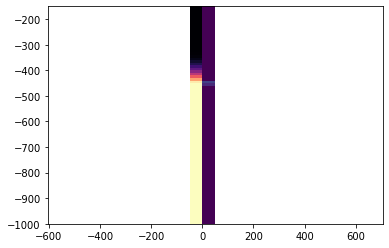

In [2198]:
solver1D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_conduit{j}_{i}.pkl")
solver1D = solver1D_from(3,1)
x1D, p1D = mdtools.downsample(solver1D, "Pressure")
_, T1D = mdtools.downsample(solver1D, "Temperature")
gradp1D = diff1D_p0(x1D, p1D)
plt.set_cmap("viridis")
mdtools.plot_mean1D(x1D, gradp1D, clims_T, xscale=50.0)
plt.set_cmap("magma")
mdtools.plot_mean1D(x1D, T1D, clims_T, xscale=50.0, xshift=-50.0)
plt.set_cmap("viridis")

plt.xlim((0,100))
plt.ylim((-1000,-150))

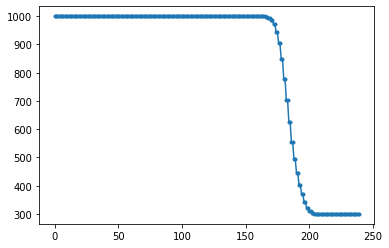

In [2158]:
%matplotlib inline
plt.plot(T1D.ravel(),'.-')

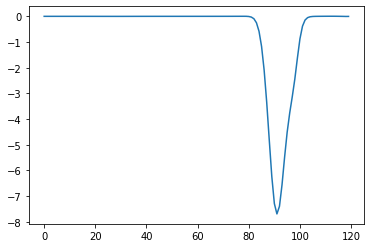

In [2190]:
plt.plot(diff1D_p0(T1D).ravel())

In [2139]:
plt.clf()
mdtools.plot_mean(x, gradp, clims)
mdtools.set_cbar(clims)
plt.set_cmap("magma")
mdtools.plot_mean(x_symm, T, (300,600))
cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()), location="left", pad=0.18)
cb.ax.set_title("$T$ (K)")
plt.set_cmap("viridis")
plt.show()

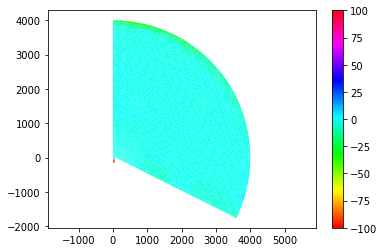

In [2037]:
clims = (-1e2, 1e2)
i = 3
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  x, p = mdtools.downsample(solver2D_from(i,j))
  mdtools.plot_mean(x, p - p0, clims)
mdtools.set_cbar(clims)

(0.0, 74.84594336353996)

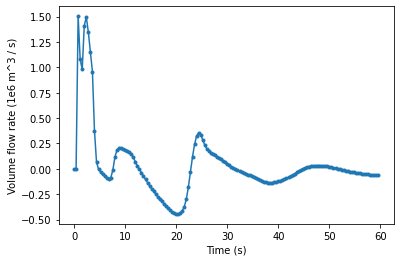

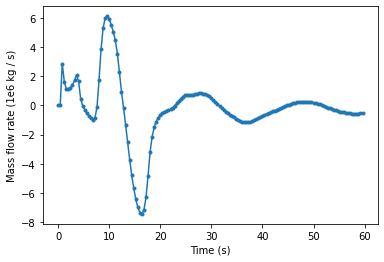

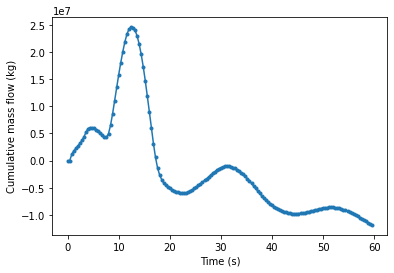

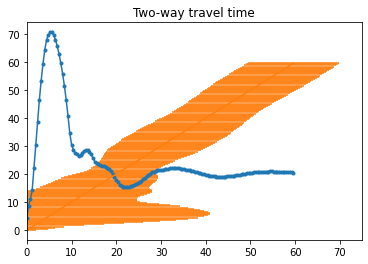

In [2089]:
plt.figure(1)
plt.plot(t_volflow, volflow/1e6, '.-')
plt.ylabel("Volume flow rate (1e6 m^3 / s)")
plt.xlabel("Time (s)")

plt.figure(2)
plt.plot(t_volflow, massflow/1e6, '.-')
plt.ylabel("Mass flow rate (1e6 kg / s)")
plt.xlabel("Time (s)")

plt.figure(3)
plt.plot(t_volflow, np.diff(t_volflow)[0] * np.cumsum(massflow), '.-')

plt.ylabel("Cumulative mass flow (kg)")
plt.xlabel("Time (s)")


plt.figure(4)
plt.plot(t_volflow, 2*t_wavetravel_array, '.-')
plt.title("Two-way travel time")

plt.errorbar(t_volflow, t_volflow, xerr=t_wavetravel_array)
plt.xlim(left=0)

<ErrorbarContainer object of 3 artists>

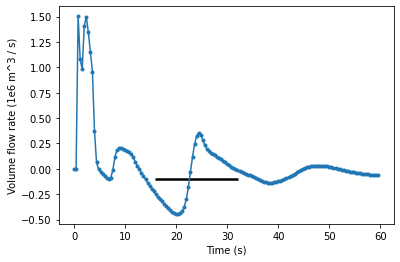

In [512]:
plt.figure(1)
plt.plot(t_volflow, volflow/1e6, '.-')
plt.ylabel("Volume flow rate (1e6 m^3 / s)")
plt.xlabel("Time (s)")

index_bar = 60
pos_bar = -0.1
plt.errorbar(t_volflow[index_bar], pos_bar, xerr=t_wavetravel_array[index_bar],  color='k', linewidth=2.5)

In [252]:
np.diff(t_volflow).shape

(119,)

In [1767]:
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_atm{j}_{i}.pkl")
solver = solver2D_from(0,3)

# solver = solver2D_from(i,3)
# solver.mesh.node_coords.shape
x, p = mdtools.downsample(solver, plot_qty="Pressure")

''' Point evaluation (linear interp) '''
import matplotlib.tri as tri
# Global triangulation using node coordinates
trtr = tri.Triangulation(solver.mesh.node_coords[...,0],
                  solver.mesh.node_coords[...,1], 
                  triangles=solver.mesh.elem_to_node_IDs)
def interp_value(x, y, u):
  # Element ID finder using trifinder (-1 if not found)
  get_elem_ID = trtr.get_trifinder()(x, y)
  if get_elem_ID == -1:
    return None
  # Get relevant triangle (type is ndarray[3, 2])
  local_nodes = \
    solver.mesh.node_coords[solver.mesh.elem_to_node_IDs[get_elem_ID,:], :]
  # Use cubic tri interpolator on relevant tri element
  return np.array([tri.CubicTriInterpolator(
    tri.Triangulation(local_nodes[:,0],local_nodes[:,1]),
    u[get_elem_ID, :, i])(x,y) for i in range(u.shape[-1])])

# HIGH
# interp_value(1750, -825, p)
# LOW
# interp_value(3000, -1450, p)
sensor_loc = (1750, -825)

# Assuming global triangulation trtr is loaded with the same solver
all_t = []
all_val = []
for i in range(1100):
  solver = solver2D_from(i,3)
  _t = solver.time
  _val_global = solver.state_coeffs
  _val = interp_value(*sensor_loc, _val_global)
  all_t.append(_t)
  all_val.append(_val)

In [2232]:
math.atan2(-825,1750)*180/math.pi

-25.240529264786794

In [2236]:
sensor_R

1934.7157413945854

In [2223]:
''' Insert -- AGU: using si '''

sensor_R = np.linalg.norm((1750, -825))
sensor_loc1 = (1750, -825)
sensor_loc2 = (sensor_R, 0)
sensor_loc3 = (1750, 825)

si_t = []
si1_val = []
si2_val = []
si3_val = []
for i in range(1100):
  solver = solver2D_from(i,3)
  si = mdtools.SolverInterpolator(solver2D_from(i,3))
  
  # _val_global = solver.state_coeffs
  # _val = interp_value(*sensor_loc, _val_global)
  si_t.append(solver.time)
  si1_val.append(si(*sensor_loc1))
  si2_val.append(si(*sensor_loc2))
  si3_val.append(si(*sensor_loc3))


In [2235]:
trim_index = 10
plt.clf()
t_series = np.array(si_t[trim_index:])
U1_series = np.array(si1_val[trim_index:])
U2_series = np.array(si2_val[trim_index:])
U3_series = np.array(si3_val[trim_index:])
physics = solver2D_from(0,3).physics
p1 = physics.compute_variable("Pressure", U1_series).squeeze()
p2 = physics.compute_variable("Pressure", U2_series).squeeze()
p3 = physics.compute_variable("Pressure", U3_series).squeeze()
plt.plot(t_series, p1 - p1[0])
plt.plot(t_series, p2 - p2[0])
plt.plot(t_series, p3 - p3[0])
plt.xlabel("$t$ (s)")
plt.ylabel("$\\Delta p$ (Pa)")

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.legend(["$-25^\circ$", "$0^\circ$", "$+25^\circ$"],fontsize=14)
plt.grid("minor")

In [ ]:
z = np.vstack(tuple(mesh.node_coords[...,:] for mesh in meshes))
bdry2nodes = {}

''' Construct map from bdry key to global node number'''
for i in range(N_meshes):
  # Read initial output for mesh i
  solver = readwritedatafiles.read_data_file(solvers_in_mesh[i][0])
  mesh = solver.mesh
  # Find linked boundaries
  linked_bdrys = [key for key, val in solver.physics.BCs.items() if "2D2D" in str(val)]
  for bdry in linked_bdrys:
    # Get nodes on boundary in domain (elem_to_node_IDs accessed at [bdry elt
    # ID, element-local node ID])
    bdry_node_IDs = [ index_shifts[i] +
      mesh.elem_to_node_IDs[bdryface.elem_ID,
        mesh.gbasis.get_local_face_principal_node_nums(
        mesh.gorder,
        bdryface.face_ID)]
      for bdryface in mesh.boundary_groups[bdry].boundary_faces
      ]
    bdry2nodes[bdry] = bdry2nodes.get(bdry, [])
    bdry2nodes[bdry].extend(np.unique(bdry_node_IDs))

# Coordinate thresholding
z_round = np.round(z,decimals=1)
_, argunique = np.unique(asblock(z_round), return_index=True)

assert(len(z) - len(argunique) == 
  sum([len(bdry2nodes[key]) for key in bdry2nodes.keys()]) / 2)
argunique.sort()

union_coords = z[argunique,:]
union_elem_to_node_IDs

array([[ 297,  546,  501],
       [ 378,  570,  132],
       [ 293,  452,  363],
       ...,
       [5582, 5606, 5380],
       [5356, 5593, 5587],
       [5401, 5616, 5519]])

In [943]:
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"tung3_atm{j}_{i}.pkl")
solver = solver2D_from(100,3)

''' Point evaluation (linear interp) '''
import matplotlib.tri as tri
from numpy.typing import ArrayLike

class SolverInterpolator():
  '''
  Interpolator over a solver's domain. Call with (x,y) to obtain state_coeffs
  at those locations. Interpolates using CubiTriInterpolator.
  '''
  def __init__(self, solver):
    self.solver = solver
    self.triangulation = tri.Triangulation(solver.mesh.node_coords[...,0],
                  solver.mesh.node_coords[...,1], 
                  triangles=solver.mesh.elem_to_node_IDs)
    # Trifinder (x,y) -> [elem_IDs]
    self.trifinder = self.triangulation.get_trifinder()
  
  def __call__(self, x:ArrayLike, y:ArrayLike) -> np.array:
    try:
      iter(x)
    except TypeError:
      x = np.array([x])
      y = np.array([y])
    solver = self.solver
    # Grab data to interpolate
    u = solver.state_coeffs
    if solver.basis.order == 1:
      out = np.full((np.array(x).ravel().shape[0], u.shape[-1]), np.nan)
      elem_IDs = self.trifinder(x, y)
      for i, elem_ID in enumerate(elem_IDs):
        if elem_ID != -1:
          # Use cubic tri interpolator using nodal values at mesh nodes
          out[i,:] = np.array([tri.CubicTriInterpolator(tri.Triangulation(
            *(solver.mesh.node_coords[
              solver.mesh.elem_to_node_IDs[elem_ID,:], :].T)),
            u[elem_ID, :, state_idx], kind="geom")(x[i],y[i])
            for state_idx in range(u.shape[-1])])
    else:
      print("Interpolator not called; solver order is not 1.")
    return out
SolverInterpolator(solver)(x_, y_)

array([[                   nan,                    nan,
                           nan,                    nan,
                           nan,                    nan,
                           nan,                    nan,
                           nan],
       [ 1.151934636430232e+00,  5.788616263468559e-03,
         9.998279121353209e-10, -2.417797511598330e-02,
         8.348208380879056e-02,  2.467236091172070e+05,
         5.788616263468559e-03,  9.998401956521361e-11,
         8.998451209217898e-10],
       [                   nan,                    nan,
                           nan,                    nan,
                           nan,                    nan,
                           nan,                    nan,
                           nan]])

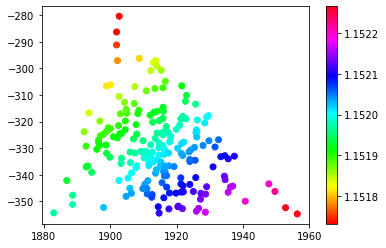

In [833]:
''' Test SolverInterpolator over random samples in convex hull of a node'''
si = UnionInterpolator(solver)
i = 0
state_idx = 0
# Grab nodes of element i
x_node = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs[i]]
plt.scatter(x_node[...,0], x_node[...,1], c=solver.state_coeffs[i,:,state_idx])
plt.colorbar()
plt.set_cmap("hsv")

# Uniformly sample convex hull of points
rand_source = np.random.rand(200,3)
rand_source /= np.sum(rand_source,axis=-1,keepdims=True)
x_sample = np.einsum("ij, jk -> ik", rand_source, x_node)
y = si(*x_sample.T)
# plt.plot(x_sample[...,0], y[...,3], '.r')
plt.scatter(x_sample[...,0], x_sample[...,1], c=y[...,state_idx])

In [944]:
class UnionInterpolator():
  '''
  Interpolator over several solvers' domains. Call with (x,y) to obtain
  state_coeffs at those locations. Interpolates using CubiTriInterpolator.
  '''
  def __init__(self, solvers):
    try:
      iter(solvers)
    except TypeError:
      solvers = [solvers]
    self.solvers = solvers
    self.interpolators = [SolverInterpolator(solver) for solver in solvers]
    self.mesh_centers = np.array([np.mean(solver.mesh.node_coords, axis=0)
      for solver in solvers])
    self.N_states = self.solvers[0].state_coeffs.shape[-1]
  
  def __call__(self, x:ArrayLike, y:ArrayLike) -> np.array:
    try:
      iter(x)
    except TypeError:
      x = np.array([x])
      y = np.array([y])
    out = np.full((np.array(x).ravel().shape[0], self.N_states), np.nan)
    for i, (x_pt, y_pt) in enumerate(zip(x, y)):
      # Set priority of solvers based on proximity to mesh center
      priority_range = np.argsort(
        np.linalg.norm(np.array([x_pt, y_pt]) - self.mesh_centers, axis=-1))
      for solver_idx in priority_range:
        interpolated_state = self.interpolators[solver_idx]([x_pt], [y_pt])
        if ~np.any(np.isnan(interpolated_state)):
          break
      out[i,:] = interpolated_state
    return out

In [901]:
solver2D_from(10,1).mesh.node_coords

array([[   0.               ,  901.1093840838123  ],
       [ 821.5071580623478  , -370.3027293124265  ],
       [  86.18033988749895 ,   -2.639320225002102],
       ...,
       [  34.22737944181641 ,  -96.49829151591707 ],
       [ 783.2248617635727  , -215.5141606185835  ],
       [ 550.9847318430373  , -131.3208561561788  ]])

In [914]:
x_mesh, _ = mdtools.downsample(solver2D_from(10,1))

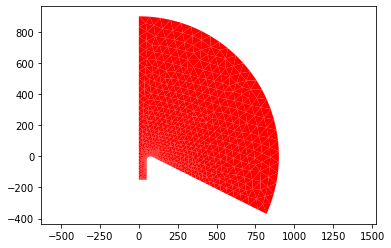

In [917]:
mdtools.plot_mean(x_mesh, x_mesh[...,0:1], (0,0))

In [733]:
u = solver.state_coeffs

tf = tri.Triangulation(solver.mesh.node_coords[...,0],
                  solver.mesh.node_coords[...,1], 
                  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()
                  
x_ = [0.1, 1800, 70000]
y_ = [2, 4, .2]
elem_ID = tf([0.1, 1800, 70000], [2, 4, .2])

SolverInterpolator(solver)(x_, y_)

array([ 1.151934636430232e+00,  5.788616263468559e-03,
        9.998279121353209e-10, -2.417797511598330e-02,
        8.348208380879056e-02,  2.467236091172070e+05,
        5.788616263468559e-03,  9.998401956521361e-11,
        8.998451209217898e-10])

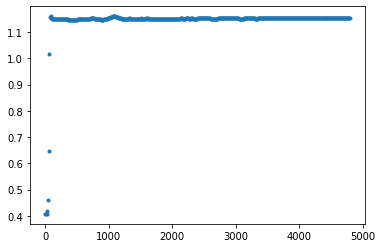

In [966]:
''' Slice analysis using UnionInterpolator '''
# Set time index
i = 10
# Set list of 2D solvers with index strides
solver_list = [solver2D_from(5*i,1), solver2D_from(i,2), solver2D_from(10*i,3),
  *[solver2D_from(i,j+1) for j in range(3,7)]]

# Check solver t
# [s.time for s in solver_list]

ui = UnionInterpolator(solver_list)
# si = SolverInterpolator(solver2D_from(10,1))

z_array = np.linspace(-150,5000,500)
r_array = np.linspace(0,50,1)
# Scatter points
z_sc, r_sc = [arr.ravel() for arr in np.meshgrid(z_array, r_array)]
q = ui(z_sc, r_sc)
plt.plot(z_sc, q[:,0], '.')

In [2068]:
# Define mapping to QOIs
qoi_names = ["Pressure", "XVelocity", "YVelocity", "SoundSpeed",
  "Temperature", "phi", "XMomentum", "YMomentum"]
qoi_map = lambda q: {qty_name: solver2D_from(0,1).physics.compute_variable(
  qty_name, np.expand_dims(q,axis=0)).squeeze() for qty_name in qoi_names}

# Define file index samples
file_idx_array = np.array(list(range(0,151,1)))
# Define sampling points
z_array = np.linspace(-150,5000,100)
r_array = np.linspace(0,50,1)
z_mg, r_mg = np.meshgrid(z_array, r_array)
# Scatter points
z_sc, r_sc = [arr.ravel() for arr in np.meshgrid(z_array, r_array)]

# Data tracks; each qty has size (n_files_read, n_pts_sampled)
qoi_all = {qoi_name: np.empty((file_idx_array.shape[0], z_sc.shape[0]))
  for qoi_name in qoi_names}
t = np.nan*np.zeros((file_idx_array.shape[0],))

for i, file_idx in enumerate(file_idx_array):
  # Set list of 2D solvers with index strides
  solver_list = [solver2D_from(5*file_idx,1), solver2D_from(file_idx,2),
    solver2D_from(10*file_idx,3),
    *[solver2D_from(file_idx,j+1) for j in range(3,7)]]
  # Construct interpolator over union of domains
  ui = UnionInterpolator(solver_list)
  # Interpolate the value q
  q = ui(r_sc, z_sc)
  # Compute QOIs
  qoi_dict = qoi_map(q)
  # Append data
  t[i] = solver_list[0].time
  for qoi_name in qoi_names:
    qoi_all[qoi_name][i,:] = qoi_dict[qoi_name]

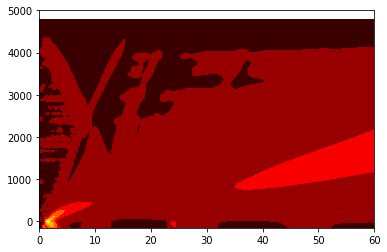

In [2069]:
t_tzmg, z_tzmg = np.meshgrid(t, z_sc)
t_tzmg.shape
t.shape
plt.contourf(t_tzmg.T, z_tzmg.T, qoi_all["YVelocity"])

C:\Users\Fredric\AppData\Local\Temp\ipykernel_32104\1522302248.py:2: RuntimeWarning: invalid value encountered in true_divide
  rho = qoi_all["YMomentum"][0,:] / qoi_all["YVelocity"][0,:]


(-1000.0, 1000.0)

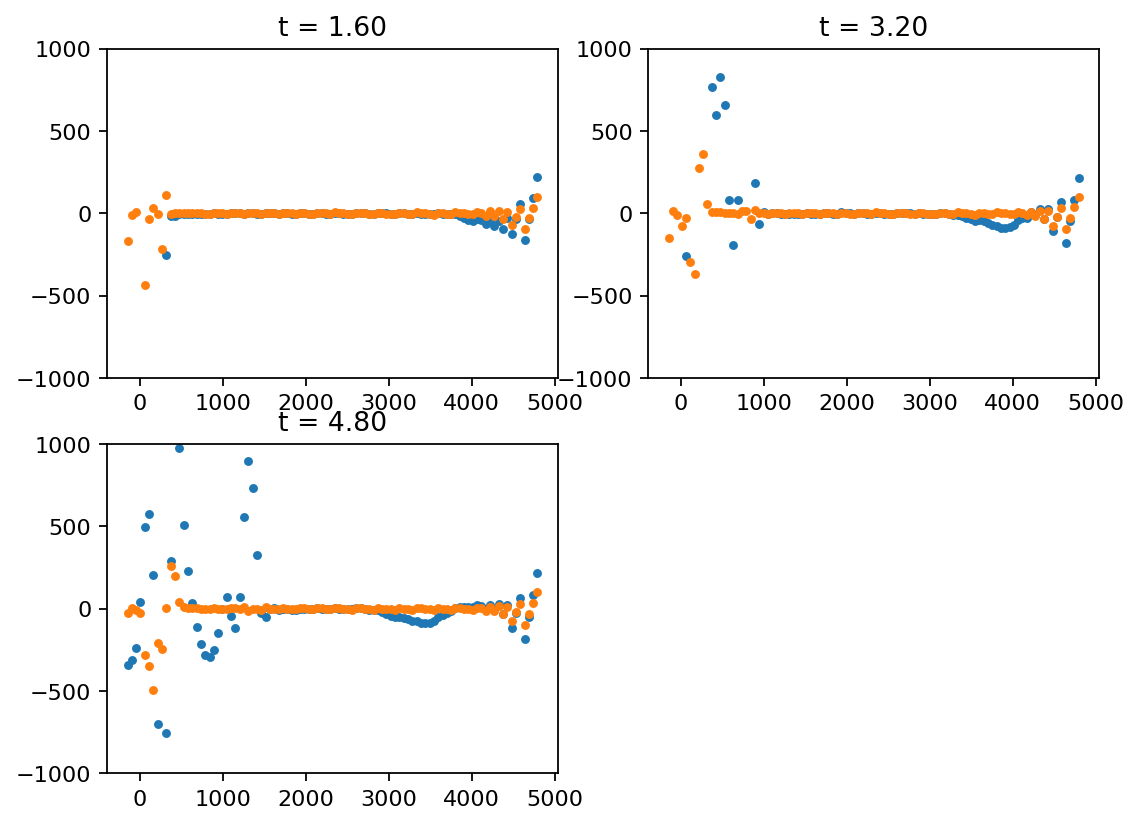

In [2070]:
qoi_all.keys()
rho = qoi_all["YMomentum"][0,:] / qoi_all["YVelocity"][0,:]
fig = plt.figure(figsize=(8, 6), dpi=160)

plt.subplot(2,2,1)
loc_i_ = 4
plt.plot(z_sc, qoi_all["Pressure"][loc_i_,:] - qoi_all["Pressure"][0,:], '.'); plt.title(f"t = {t[loc_i_]:.2f}")
plt.plot(z_sc, qoi_all["XMomentum"][loc_i_,:]*qoi_all["SoundSpeed"][loc_i_,:], '.'); plt.title(f"t = {t[loc_i_]:.2f}")
plt.ylim((-1000, 1000))

plt.subplot(2,2,2)
loc_i_ = 8
plt.plot(z_sc, qoi_all["Pressure"][loc_i_,:] - qoi_all["Pressure"][0,:], '.'); plt.title(f"t = {t[loc_i_]:.2f}")
plt.plot(z_sc, qoi_all["XMomentum"][loc_i_,:]*qoi_all["SoundSpeed"][loc_i_,:], '.'); plt.title(f"t = {t[loc_i_]:.2f}")
plt.ylim((-1000, 1000))

plt.subplot(2,2,3)
loc_i_ = 12
plt.plot(z_sc, qoi_all["Pressure"][loc_i_,:] - qoi_all["Pressure"][0,:], '.'); plt.title(f"t = {t[loc_i_]:.2f}")
plt.plot(z_sc, qoi_all["XMomentum"][loc_i_,:]*qoi_all["SoundSpeed"][loc_i_,:], '.'); plt.title(f"t = {t[loc_i_]:.2f}")
plt.ylim((-1000, 1000))


Done


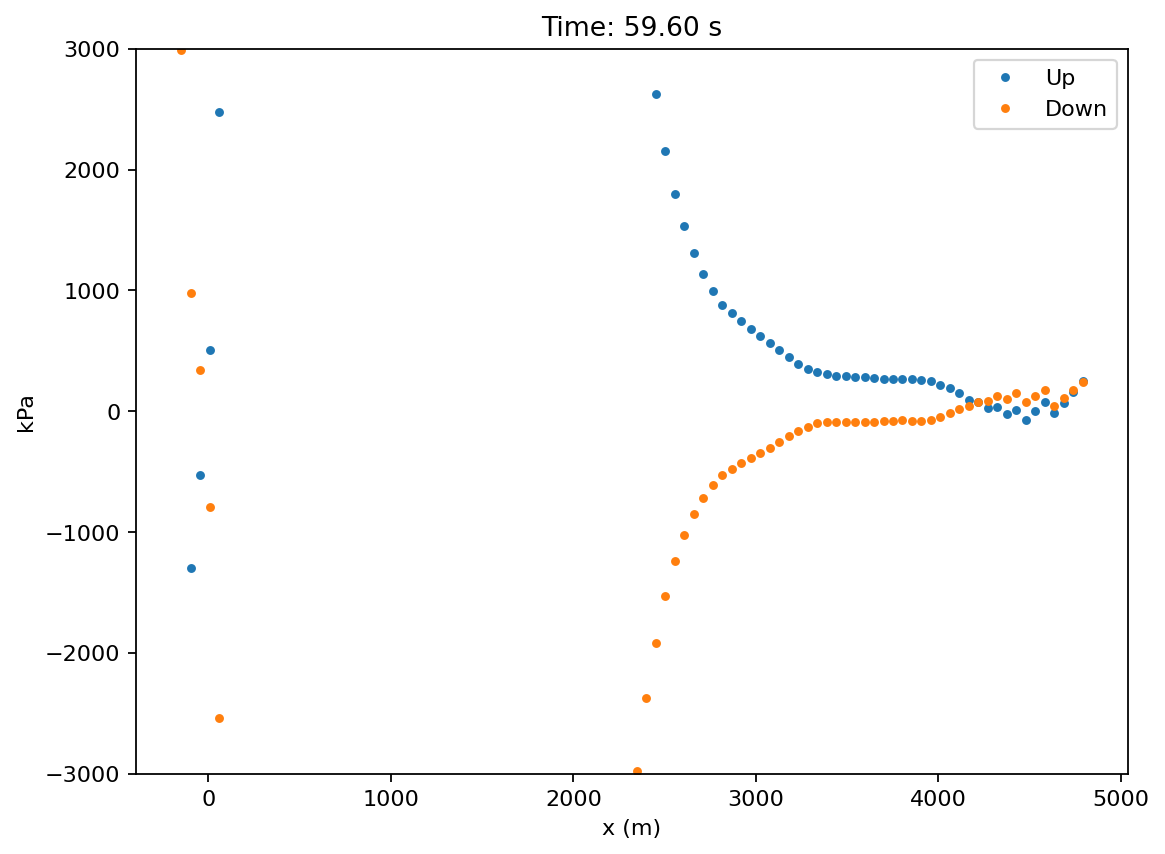

In [1063]:
outfilename = "tung3_centerline_charboth"
FFwriter = animation.FFMpegWriter()
fig = plt.figure(figsize=(8, 6), dpi=160)
FFwriter.setup(fig, f"{outfilename}.mp4")

cplus = lambda i: 0.5 * (qoi_all["Pressure"][i,:] - qoi_all["Pressure"][0,:] + qoi_all["YMomentum"][i,:]*qoi_all["SoundSpeed"][i,:])
cminus = lambda i: 0.5 * (qoi_all["Pressure"][i,:] - qoi_all["Pressure"][0,:] - qoi_all["YMomentum"][i,:]*qoi_all["SoundSpeed"][i,:])

for i in range(0,150,1):
  plt.clf()
  plt.plot(z_sc, cplus(i), '.')
  plt.title(f"t = {t[i]:.2f}")
  # plt.plot(z_sc, qoi_all["XMomentum"][i,:]*qoi_all["SoundSpeed"][i,:], '.')
  plt.plot(z_sc, cminus(i), '.')
  # plt.title(f"t = {t[i]:.2f}")
  plt.ylim((-3000, 3000))
  plt.xlabel("x (m)")
  plt.ylabel("kPa")
  plt.legend(["Up", "Down"])
  plt.title(f"Time: {t[i]:.2f} s")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

------------------

In [1726]:
# Gravity settling analysis
solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  f"../gravity_settling/tungSS_atm{j}_{i}.pkl")

In [1725]:
# (Import) Plot |grad p|
import matplotlib.animation as animation

outfilename = "tunggrav_pressuregrad_dpi120_"
fig = plt.figure(figsize=(8, 6), dpi=120)
FFwriter = animation.FFMpegWriter()
FFwriter.setup(fig, f"{outfilename}.mp4")

# plot_idx = 20

for plot_idx in [i+1 for i in range(0,30,1)]:
  plt.clf()
  clims = (0,10)

  domain_indices = [1,2,3]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)

    sample_basis_phys_grad_elems = []
    sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
    for elem_ID in range(solver.mesh.num_elems):
      solver.basis.get_basis_val_grads(
              sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
              get_val=True,
              get_ref_grad=True,
              get_phys_grad=True,
              ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
      sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
    # du_ij = np.einsum('ijnl, ink -> ijkl',
    #       np.array(sample_basis_phys_grad_elems),
    #       solver.physics.compute_variable("Pressure", solver.state_coeffs))
    gradp = np.einsum('ijnl, ink -> ijkl',
        np.array(sample_basis_phys_grad_elems),
        np.sum(solver.state_coeffs[:,:,0:3],axis=2,keepdims=True))
    gradp[...,1] += 1.152132904521597 * 9.8
    normgradp = np.linalg.norm(
      gradp,
      axis=2, keepdims=True)
    x, _ = mdtools.downsample(solver)
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    mdtools.plot_mean(x, normgradp, clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("$|\\nabla p - \\rho_0 g|$ (Pa/m)")
  # plt.show()
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

Done


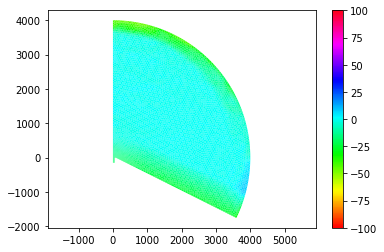

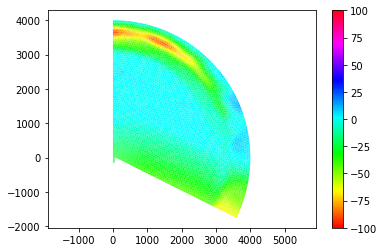

In [1739]:
%matplotlib inline
plt.figure(1)
i = 1
clims = (-1e2, 1e2)
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  _, p  = mdtools.downsample(solver2D_from(i,j))
  mdtools.plot_mean(x, p-p0, clims)
mdtools.set_cbar(clims)

plt.figure(2)
i = 2
clims = (-1e2, 1e2)
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  _, p  = mdtools.downsample(solver2D_from(i,j))
  mdtools.plot_mean(x, p-p0, clims)
mdtools.set_cbar(clims)

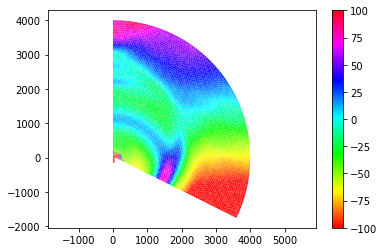

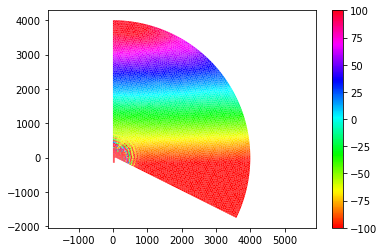

In [1740]:
plt.figure(3)
i = 10
clims = (-1e2, 1e2)
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  _, p  = mdtools.downsample(solver2D_from(i,j))
  mdtools.plot_mean(x, p-p0, clims)
mdtools.set_cbar(clims)

plt.figure(4)
i = 30
clims = (-1e2, 1e2)
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  _, p  = mdtools.downsample(solver2D_from(i,j))
  mdtools.plot_mean(x, p-p0, clims)
mdtools.set_cbar(clims)

In [1747]:
physics = solver2D_from(0, 3).physics
physics.Gas[1]

{'R': 461.3762486126525,
 'c_p': 2288.0,
 'c_v': 1826.6237513873475,
 'gamma': 1.2525841724450535}

In [ ]:
i = 30
clims = (-1e2, 1e2)
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  _, p  = mdtools.downsample(solver2D_from(i,j))
  mdtools.plot_mean(x, p-p0, clims)
mdtools.set_cbar(clims)


In [1758]:
%autoreload 0

In [1759]:
hs0 = 287.8718812430633*300/9.8
# Compute pressure linear in elevation
p_hydr = 1e5 * (1.0 - (x[:,:,1:2] + 150)/hs0).squeeze(axis=2)

In [1760]:
p_hydr

array([[ 88261.55157648055 ,  86582.45537876805 ,  87213.46949927913 ],
       [ 61815.654143188745,  61949.758590298276,  63277.56653686774 ],
       [104742.77770298746 , 105516.86796865774 , 103306.3531965835  ],
       ...,
       [ 58239.79832014274 ,  58742.058524117136,  58031.10927420645 ],
       [ 53222.81497968975 ,  53971.56287071706 ,  53988.59386171462 ],
       [ 66051.03715926052 ,  65033.6530964347  ,  64726.5214099044  ]])

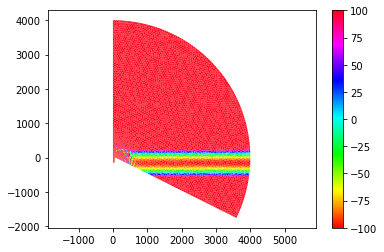

In [1766]:
i = 30
clims = (-1e2, 1e2)
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  _, p  = mdtools.downsample(solver2D_from(i,j))
  hs0 = 287.8718812430633*solver2D_from(0,j).physics.compute_variable("Temperature", solver2D_from(0,j).state_coeffs)/9.8
  p_hydr = 1e5 * (1.0 - (x[:,:,1:2] + 150)/hs0)
  mdtools.plot_mean(x, p-p_hydr, clims)
mdtools.set_cbar(clims)

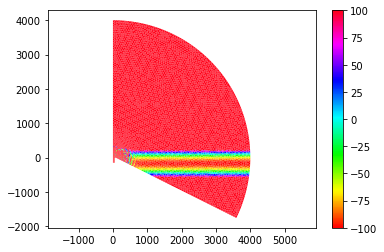

In [1765]:
i = 30
clims = (-1e2, 1e2)
for j in [1,2,3,4,5,6]:
  x, p0 = mdtools.downsample(solver2D_from(0,j))
  _, p  = mdtools.downsample(solver2D_from(i,j))
  hs0 = 287.0*solver2D_from(0,j).physics.compute_variable("Temperature", solver2D_from(0,j).state_coeffs)/9.8
  p_hydr = 1e5 * (1.0 - (x[:,:,1:2] + 150)/hs0)
  mdtools.plot_mean(x, p-p_hydr, clims)
mdtools.set_cbar(clims)

In [1752]:
y = solver2D_from(0, 3).state_coeffs[...,0:2] \
  / solver2D_from(0, 3).state_coeffs[...,0:2].sum(axis=-1,keepdims=True)
np.dot(y[...,0:2], [physics.Gas[0]["R"], physics.Gas[1]["R"]]), physics.Gas[0]["R"]

(array([[287.8718812430633, 287.8718812430633, 287.8718812430633],
        [287.8718812430633, 287.8718812430633, 287.8718812430633],
        [287.8718812430633, 287.8718812430633, 287.8718812430633],
        ...,
        [287.8718812430633, 287.8718812430633, 287.8718812430633],
        [287.8718812430633, 287.8718812430633, 287.8718812430633],
        [287.8718812430633, 287.8718812430633, 287.8718812430633]]),
 287.0)

Done


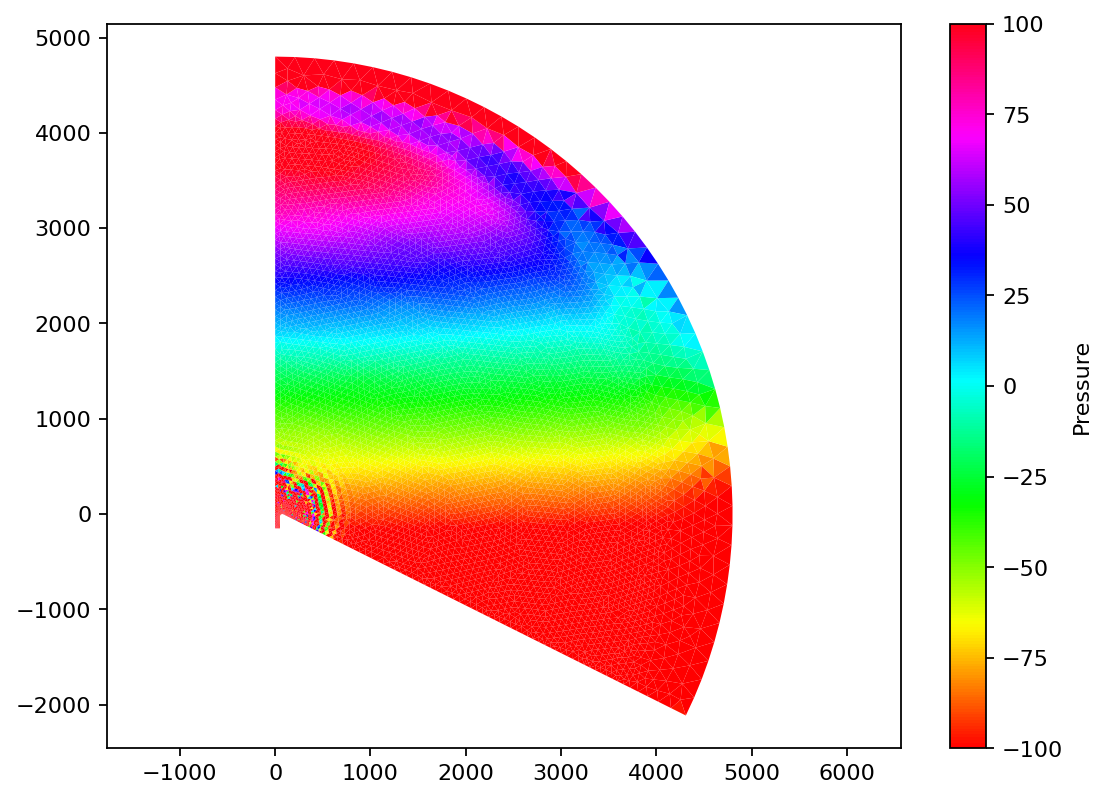

In [1743]:
# (Import) Plot pressure
import matplotlib.animation as animation

outfilename = "tunggrav_p"
FFwriter = animation.FFMpegWriter()
FFwriter.setup(plt.figure(figsize=(8, 6), dpi=160), f"{outfilename}.mp4")

for plot_idx in [i+1 for i in range(0,30)]:
  plt.clf()
  clims = (-1e2, 1e2)

  domain_indices = [1,2,3,4,5,6,7]
  for dom_idx in domain_indices:
    solver = solver2D_from(plot_idx, dom_idx)
    x, p = mdtools.downsample(solver)
    _, p0 = mdtools.downsample(solver2D_from(0, dom_idx))
    # mdtools.custom_plot_2D(x, vorticity, solver, levels=None)
    mdtools.plot_mean(x, p - p0, clims)#(0,25))

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("Pressure")
  FFwriter.grab_frame()

FFwriter.finish()
print("Done")

In [2016]:
import glob
from pickle import UnpicklingError

''' General ((x,y), t) interpolator. Performs linear interpolation in t.
Automatic file ingestion for given file path + prefix. '''

class XYTInterpolator():

  N_DECIMALS_THRESHOLDING = 1

  def __init__(self, file_path):
    # Convert file path with file radical to search string
    search_str = f"{file_path}*.pkl"

    ''' Create data model and ingest data. '''
    file_names = glob.glob(search_str)
    # Get list of initial meshes TODO: needs a mesh from somewhere even if _0 DNE
    initials = [fname for fname in file_names if fname[-6:] == "_0.pkl"]
    meshes = [readwritedatafiles.read_data_file(fname).mesh for fname in initials]
    N_meshes = len(meshes)
    solvers_in_mesh = [[] for i in range(N_meshes)]
    timeline_in_mesh = [[] for i in range(N_meshes)]
    # Initialize mapping fname -> file_data
    data_rep = {}
    # Read physics from first encountered file
    physics = readwritedatafiles.read_data_file(file_names[0]).physics
    N_states = physics.NUM_STATE_VARS
    # Define block view (compressing (x,y) -> v)
    asblock = lambda x: x.ravel().view(np.dtype((np.void, 2*x.dtype.itemsize)))

    for fname in file_names:
      try:
        # Read file
        solver = readwritedatafiles.read_data_file(fname)
      except UnpicklingError:
        print(f"Skipping {fname}: unpicklable file.")
        continue
      if solver.basis.order == 1:
        ''' This postprocessor is implemented for order == 1 for 2D triangular
        elements. TODO: generalize to other orders, where the nodes are not
        necessarily located at the triangle vertices. The latter assumption
        allows simple linear interpolation in 2D tris. '''
      else:
        raise NotImplementedError("Solver basis is not order 1.")
      # Match mesh by node coordinates (exact equality of floats) interpreted as
      # 2*float64 blocks
      mesh_index = np.argwhere(
        [len(np.union1d(asblock(solver.mesh.node_coords),
        asblock(mesh.node_coords))) == len(solver.mesh.node_coords)
        for mesh in meshes]).ravel()[0]
      # Save simplified representation of current file
      data_rep[fname] = ({
        "t": solver.time,
        "mesh_index": mesh_index,
        "state_coeffs": solver.state_coeffs,
      })
      # Save name in list solvers_in_mesh
      solvers_in_mesh[mesh_index].append(fname)

    ''' Postprocess data entries for each mesh '''
    for i in range(N_meshes):
      # Sort files by increasing t in each mesh
      solvers_in_mesh[i].sort(key=lambda fname: data_rep[fname]["t"])
      # Remove duplicate solvers at each time
      timeline_in_mesh[i], argunique = np.unique([data_rep[fname]["t"]
        for fname in solvers_in_mesh[0]], return_index=True)
      solvers_in_mesh[i] = list(np.array(solvers_in_mesh[i])[argunique])

    ''' Construct union trifinder '''
    # Compute shifts to assign unique node num to union of meshes
    index_shifts = np.roll(np.cumsum([mesh.num_nodes for mesh in meshes]),1)
    index_shifts[0] = 0
    # Construct mapping from element num (row) to ID in union of meshes
    union_elem_to_node_IDs = np.vstack([mesh.elem_to_node_IDs+shift
      for mesh, shift in zip(meshes, index_shifts)])
    # Construct global set of nodes, with duplicate nodes
    z = np.vstack(tuple(mesh.node_coords[...,:] for mesh in meshes))

    ''' Get map from bdry key (name of interface bdry) to global node
    number. Useful if the nodes lying on boundaries need to be accessed in the
    union view. Currently only used along with argunique to verify rounding
    threshold is sufficient; the mapping from original node IDs to new node IDs,
    with duplicates removed, needs more information than argunique. '''
    bdry2nodes = {}
    for i in range(N_meshes):
      # Read initial output for mesh i
      solver = readwritedatafiles.read_data_file(solvers_in_mesh[i][0])
      mesh = solver.mesh
      # Find linked boundaries
      linked_bdrys = [key for key, val in solver.physics.BCs.items()
        if "2D2D" in str(val)]
      for bdry in linked_bdrys:
        # Get nodes on boundary in domain (elem_to_node_IDs accessed at [bdry elt
        # ID, element-local node ID])
        bdry_node_IDs = [ index_shifts[i] +
          mesh.elem_to_node_IDs[bdryface.elem_ID,
            mesh.gbasis.get_local_face_principal_node_nums(
            mesh.gorder,
            bdryface.face_ID)]
          for bdryface in mesh.boundary_groups[bdry].boundary_faces
          ]
        bdry2nodes[bdry] = bdry2nodes.get(bdry, [])
        bdry2nodes[bdry].extend(np.unique(bdry_node_IDs))
    # Coordinate thresholding for approximate equality at boundaries
    z_round = np.round(z,decimals=XYTInterpolator.N_DECIMALS_THRESHOLDING)
    # Get sort index for unique coordinates (up to rounding)
    _, argunique = np.unique(asblock(z_round), return_index=True)
    # Assert number of unique nodes is equal to number of nodes minus half of the
    # nodes with duplicated coordinates (i.e. num nodes on boundaries shared by
    # two domains).
    assert(len(z) - len(argunique) == 
      sum([len(bdry2nodes[key]) for key in bdry2nodes.keys()]) / 2)

    ''' Construct global triangle finder. '''
    # Map from old node IDs (with duplicates) to new node IDs (without
    # duplicates and contiguous)
    map2new = np.zeros((len(z_round),), dtype=int)
    # Sorted sequence of multi-byte blocks
    sortidx = np.argsort(asblock(z_round))
    seq_sorted = asblock(z_round)[sortidx]
    # Construction of unique node coords
    unique_nodes = [z[sortidx][0]]

    # Construct mapping to contiguous unique coordinates
    k = 0
    for i in range(len(map2new)):
      if i >= 1 and seq_sorted[i] != seq_sorted[i-1]:
        k += 1
        unique_nodes.append(z[sortidx][i])
      map2new[i] = k

    unique_nodes = np.array(unique_nodes)
    # Migrate references to old node IDs to new node IDs in each triangle
    invsortidx = sortidx.argsort()
    union_elem_to_node_IDs_unique = map2new[invsortidx[union_elem_to_node_IDs]]
    # Construct global trifinder
    global_trifinder = tri.Triangulation(*unique_nodes.T, 
      union_elem_to_node_IDs_unique).get_trifinder()

    ''' Perform other initialization tasks needed by methods. '''
    # Compute cumulative counter for elements
    #   (N < elt_count[i] and (i == 0 or N > elt_count[i-1]) in element i)
    elt_count = np.cumsum([mesh.elem_to_node_IDs.shape[0] for mesh in meshes])
    # Construct domain-specific triangulation
    local_triangulations = [tri.Triangulation(mesh.node_coords[...,0],
      mesh.node_coords[...,1], 
      triangles=mesh.elem_to_node_IDs) for mesh in meshes]

    ''' Export variables '''
    self.physics = physics
    self.data_model = {
      "N_meshes": N_meshes,
      "meshes": meshes,
      "solvers_in_mesh": solvers_in_mesh,
      "timeline_in_mesh": timeline_in_mesh,
      "data_rep" : data_rep,
      "local_triangulations": local_triangulations,
    }
    self.global_trifinder = global_trifinder
    self.elt_count = elt_count

  def domain_identifier(self, x:float, y:float) -> int:
    ''' Mapping from x, y -> domain id (mesh/domain index in internal data
    model). '''
    dom_idx = self.global_trifinder(x,y)
    if dom_idx == -1:
      return -1
    else:
      return np.where(self.global_trifinder(x,y) < self.elt_count)[0][0]

  def __call__(self, x:np.array, y:np.array, t:np.array) -> np.array:
    ''' Dispatch x, y to each mesh. For each domain, interpolate in t, and then
    interpolate in space. '''
    data_rep = self.data_model["data_rep"]
    solvers_in_mesh = self.data_model["solvers_in_mesh"]
    timeline_in_mesh = self.data_model["timeline_in_mesh"]
    meshes = self.data_model["meshes"]
    local_triangulations = self.data_model["local_triangulations"]
    N_meshes = self.data_model["N_meshes"]
    N_states = self.physics.NUM_STATE_VARS
    # Construct list of references to data on each mesh, indexed by time
    state_coeffs_global_time = [[data_rep[sname]["state_coeffs"] 
      for sname in solvers_in_mesh[i]]
      for i in range(N_meshes)]
    # Identify domain with internal index
    domain_dispatch_idx = [self.domain_identifier(x_,y_) for x_,y_ in zip(x,y)]
    # Set mapping for dispatching each (x, y) to a mesh index:
    #   list(tuple(index, point:tuple))
    dispatch_map = [[] for dom_idx in range(N_meshes)]
    for i, (x_,y_) in enumerate(zip(x,y)):
      dispatch_map[self.domain_identifier(x_,y_)].append((i,(x_,y_)))
    # Allocate output (len(t), len(x_), num_states)
    out = np.full((t.shape[0], np.array(x).ravel().shape[0], N_states), np.nan)
    for dom_idx, mesh_workload in enumerate(dispatch_map):
      ''' Perform interpolation on each mesh. '''
      if len(mesh_workload) == 0:
        continue
      # Get indices for placing results (i_loc) and point geometry x_loc, y_loc
      i_loc, x_loc = list(zip(*mesh_workload))
      x_loc, y_loc = list(zip(*x_loc))
      # Compute interpolated time-indices as floats
      t_index_interp = (np.interp(t,
        timeline_in_mesh[dom_idx], np.array(range(len(timeline_in_mesh[dom_idx])))))
      # Mark invalid t interpolate requests (do not extrapolate)
      t_index_interp[t > timeline_in_mesh[dom_idx].max()] = np.nan
      t_index_interp[t < timeline_in_mesh[dom_idx].min()] = np.nan
      # Pull data
      for j, t_index in enumerate(t_index_interp):
        if not np.isnan(t_index):
          l = np.floor(t_index).astype(int)
          u = np.ceil(t_index).astype(int)
          theta = t_index - l
          assert(theta == np.clip(theta,0,1))
          # Linear interpolate in time the state coeffs over the domain
          U = (1-theta) * state_coeffs_global_time[dom_idx][l] \
            + theta * state_coeffs_global_time[dom_idx][u]
          # Compute subset x
          elem_IDs = local_triangulations[dom_idx].get_trifinder()(x_loc, y_loc)
          for i, elem_ID in enumerate(elem_IDs):
            if elem_ID != -1:
              # Use cubic tri interpolator using nodal values at mesh nodes
              out[j,i_loc[i],:] = np.array([tri.CubicTriInterpolator(tri.Triangulation(
                *(meshes[dom_idx].node_coords[
                  meshes[dom_idx].elem_to_node_IDs[elem_ID,:], :].T)),
                U[elem_ID, :, state_idx], kind="geom")(x_loc[i],y_loc[i])
                for state_idx in range(N_states)])
    return out

In [2019]:
''' XYTInterpolator testing '''
file_path = "../tungurahua/tung3_atm"
# Test interpolation target
xyti = XYTInterpolator(file_path)

IndexError: index 152 is out of bounds for axis 0 with size 152

In [ ]:
x, p = mdtools.downsample("")

In [2018]:
x = 0*np.linspace(0,2000,100)
y = np.linspace(0,2000,100)
t = np.linspace(0,60,10)
xyti(x,y,t)

array([[[1.152132904521597e+00, 5.789612585535719e-03,
         1.000000000000000e-09, ..., 5.789612585535719e-03,
         1.000000000000000e-10, 9.000000000000002e-10],
        [1.152132904521597e+00, 5.789612585535721e-03,
         1.000000000000000e-09, ..., 5.789612585535721e-03,
         1.000000000000000e-10, 9.000000000000000e-10],
        [1.152132904521597e+00, 5.789612585535722e-03,
         1.000000000000000e-09, ..., 5.789612585535722e-03,
         1.000000000000000e-10, 9.000000000000002e-10],
        ...,
        [1.152132904521597e+00, 5.789612585535721e-03,
         9.999999999999999e-10, ..., 5.789612585535721e-03,
         1.000000000000000e-10, 9.000000000000001e-10],
        [1.152132904521597e+00, 5.789612585535722e-03,
         1.000000000000000e-09, ..., 5.789612585535722e-03,
         1.000000000000000e-10, 9.000000000000000e-10],
        [1.152132904521596e+00, 5.789612585535721e-03,
         1.000000000000000e-09, ..., 5.789612585535721e-03,
         1.000000

In [2001]:
import math

# x = np.array([0])
# y = np.array([2000])
x = 0*np.linspace(0,2000,100)
y = np.linspace(0,2000,100)
t = np.linspace(0,60,10)

# Construct list of references to data on each mesh, indexed by time
state_coeffs_global_time = [[data_rep[sname]["state_coeffs"] 
  for sname in solvers_in_mesh[i]]
  for i in range(N_meshes)]
# Identify domain with internal index
domain_dispatch_idx = [domain_identifier(x_,y_) for x_,y_ in zip(x,y)]
# Set mapping for dispatching each (x, y) to a mesh index:
#   list(tuple(index, point:tuple))
dispatch_map = [[] for dom_idx in range(N_meshes)]
for i, (x_,y_) in enumerate(zip(x,y)):
  dispatch_map[domain_identifier(x_,y_)].append((i,(x_,y_)))
# Allocate output (len(t), len(x_), num_states)
out = np.full((t.shape[0], np.array(x).ravel().shape[0], N_states), np.nan)
for dom_idx, mesh_workload in enumerate(dispatch_map):
  ''' Perform interpolation on each mesh. '''
  if len(mesh_workload) == 0:
    continue
  # Get indices for placing results (i_loc) and point geometry x_loc, y_loc
  i_loc, x_loc = list(zip(*mesh_workload))
  x_loc, y_loc = list(zip(*x_loc))
  # Compute interpolated time-indices as floats
  t_index_interp = (np.interp(t,
    timeline_in_mesh[dom_idx], np.array(range(len(timeline_in_mesh[dom_idx])))))
  # Mark invalid t interpolate requests (do not extrapolate)
  t_index_interp[t > timeline_in_mesh[dom_idx].max()] = np.nan
  t_index_interp[t < timeline_in_mesh[dom_idx].min()] = np.nan
  # Pull data
  for j, t_index in enumerate(t_index_interp):
    if not np.isnan(t_index):
      l = np.floor(t_index).astype(int)
      u = np.ceil(t_index).astype(int)
      theta = t_index - l
      assert(theta == np.clip(theta,0,1))
      # Linear interpolate in time the state coeffs over the domain
      U = (1-theta) * state_coeffs_global_time[dom_idx][l] \
        + theta * state_coeffs_global_time[dom_idx][u]
      # Compute subset x
      elem_IDs = triangs[dom_idx].get_trifinder()(x_loc, y_loc)
      for i, elem_ID in enumerate(elem_IDs):
        if elem_ID != -1:
          # Use cubic tri interpolator using nodal values at mesh nodes
          out[j,i_loc[i],:] = np.array([tri.CubicTriInterpolator(tri.Triangulation(
            *(meshes[dom_idx].node_coords[
              meshes[dom_idx].elem_to_node_IDs[elem_ID,:], :].T)),
            U[elem_ID, :, state_idx], kind="geom")(x_loc[i],y_loc[i])
            for state_idx in range(N_states)])

In [2004]:
p = physics.compute_variable("Pressure", out)

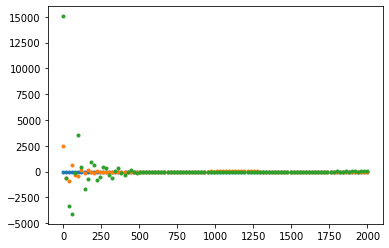

In [2012]:
for it in [0,3,-1]:
  plt.plot(y, p[it,...] - p[0,...], '.')

In [1932]:
y

array([   0.              ,   20.2020202020202 ,   40.4040404040404 ,
         60.6060606060606 ,   80.8080808080808 ,  101.01010101010101,
        121.2121212121212 ,  141.4141414141414 ,  161.6161616161616 ,
        181.8181818181818 ,  202.02020202020202,  222.2222222222222 ,
        242.4242424242424 ,  262.6262626262626 ,  282.8282828282828 ,
        303.030303030303  ,  323.2323232323232 ,  343.4343434343434 ,
        363.6363636363636 ,  383.83838383838383,  404.04040404040404,
        424.2424242424242 ,  444.4444444444444 ,  464.6464646464646 ,
        484.8484848484848 ,  505.050505050505  ,  525.2525252525252 ,
        545.4545454545454 ,  565.6565656565656 ,  585.8585858585858 ,
        606.060606060606  ,  626.2626262626262 ,  646.4646464646464 ,
        666.6666666666666 ,  686.8686868686868 ,  707.070707070707  ,
        727.2727272727273 ,  747.4747474747475 ,  767.6767676767677 ,
        787.8787878787879 ,  808.0808080808081 ,  828.2828282828282 ,
        848.48484848

In [1797]:
np.array([data_rep[s]["t"] for s in solvers_in_mesh[0]]) - timeline_in_mesh

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [1791]:
data_rep[]["state_coeffs"]

{'../gravity_settling\\tungSS_atm1_0.pkl': {'t': 0.0,
  'mesh_index': 0,
  'state_coeffs': array([[[1.152132904521597e+00, 5.789612585535720e-03,
           1.000000000000000e-09, ..., 5.789612585535720e-03,
           1.000000000000000e-10, 9.000000000000001e-10],
          [1.152132904521597e+00, 5.789612585535719e-03,
           1.000000000000000e-09, ..., 5.789612585535719e-03,
           1.000000000000000e-10, 9.000000000000001e-10],
          [1.152132904521597e+00, 5.789612585535720e-03,
           1.000000000000000e-09, ..., 5.789612585535720e-03,
           1.000000000000000e-10, 9.000000000000001e-10]],
  
         [[1.152132904521597e+00, 5.789612585535720e-03,
           1.000000000000000e-09, ..., 5.789612585535720e-03,
           1.000000000000000e-10, 9.000000000000001e-10],
          [1.152132904521597e+00, 5.789612585535719e-03,
           1.000000000000000e-09, ..., 5.789612585535719e-03,
           1.000000000000000e-10, 9.000000000000001e-10],
          [1.152132904

In [1777]:
np.array(range(len(timeline_in_mesh[i])))
len()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [1683]:
# Map from old node coordinates to new node coordinates
map2new = np.zeros((len(z_round),), dtype=int)
# Sorted sequence of multi-byte blocks
seq_sorted = asblock(z_round)[sortidx]
# Construction of unique node coords
unique_nodes = [z[sortidx][0]]

k = 0
for i in range(len(map2new)):
  if i >= 1 and seq_sorted[i] != seq_sorted[i-1]:
    k += 1
    unique_nodes.append(z[sortidx][i])
  map2new[i] = k

unique_nodes = np.array(unique_nodes)
# Compute mapping from element to unique node IDs
# union_elem_to_node_IDs_sorted = union_elem_to_node_IDs.copy()
# union_elem_to_node_IDs_sorted[sortidx] = union_elem_to_node_IDs_sorted
union_elem_to_node_IDs_unique = map2new[invsortidx[union_elem_to_node_IDs_sorted]]

In [1631]:
%matplotlib tk
plt.plot(*unique_nodes[union_elem_to_node_IDs_unique[:,0],:].T, '.')

In [1684]:
plt.clf()
for i in range(union_elem_to_node_IDs_unique.shape[0]):
  plt.plot(*unique_nodes[union_elem_to_node_IDs_unique[i,:],:].T, '.-');
  if i % 50 == 0:
    plt.show()

# for i in range(union_elem_to_node_IDs.shape[0]):
#   plt.plot(*z[union_elem_to_node_IDs[i,:],:].T, '.-');
#   if i % 50 == 0:
#     plt.show()



In [1688]:
tri.Triangulation(*unique_nodes.T, union_elem_to_node_IDs_unique).get_trifinder()(500, 500)

array(811, dtype=int32)

In [1343]:

for bdry in linked_bdrys:
  # Get nodes on boundary in domain (elem_to_node_IDs accessed at [bdry element
  # ID, element-local node ID])
  bdry_node_IDs = [
    solver.mesh.elem_to_node_IDs[bdryface.elem_ID,
      solver.mesh.gbasis.get_local_face_principal_node_nums(
      solver.mesh.gorder,
      bdryface.face_ID)]
    for bdryface in solver.mesh.boundary_groups[bdry].boundary_faces
    ]


In [1153]:
[val["t"] for key, val in file_handles.items() if val["mesh_index"] == 1]

[0.0,
 2.0000000000000013,
 19.999999999999794,
 21.999999999998685,
 23.999999999997577,
 25.99999999999647,
 27.99999999999536,
 29.99999999999425,
 31.999999999993143,
 33.99999999999559,
 35.99999999999803,
 38.000000000000476,
 3.999999999999781,
 40.00000000000292,
 42.000000000005365,
 44.00000000000781,
 46.00000000001025,
 48.0000000000127,
 50.00000000001514,
 52.000000000017586,
 54.00000000002003,
 56.000000000022474,
 58.00000000002492,
 5.999999999999561,
 60.00000000002736,
 7.999999999999341,
 10.000000000000009,
 12.000000000000677,
 14.000000000001345,
 16.00000000000201,
 18.000000000000902,
 60.00000000002736]

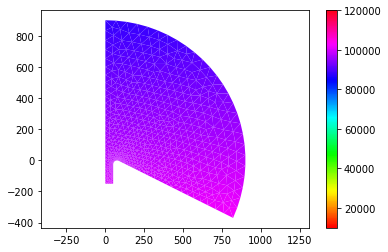

In [1070]:
x, p = mdtools.downsample(solver2D_from(0,1))
clims = (0.1e5, 1.2e5)
mdtools.plot_mean(x, p, clims)
cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
# cb.set_label("Acoustic impedance")

---------------------

In [2076]:
len(all_val)
all_val[0]

array([1.152132904521596e+00, 5.789612585535720e-03,
       9.999999999999999e-10, 0.000000000000000e+00,
       0.000000000000000e+00, 2.704079452962563e+05,
       5.789612585535720e-03, 9.999999999999998e-11,
       8.999999999999998e-10])

C:\Users\Fredric\AppData\Local\Temp\ipykernel_32104\697551041.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t, p/u_norm, '.')


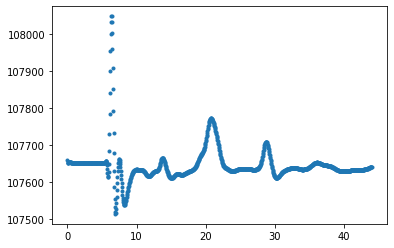

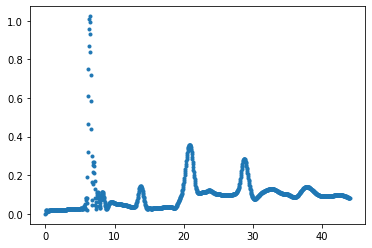

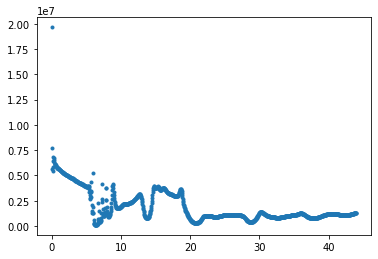

In [2071]:
# Series analysis
t = np.array(all_t)
compute_qty = lambda qty : np.array([
  solver.physics.compute_variable(qty, np.expand_dims(state_coeffs,axis=(0,1))) 
  for state_coeffs in all_val])
p = compute_qty("Pressure").squeeze()
u_norm = compute_qty("Velocity").squeeze()
plt.figure(1)
plt.plot(t, p, '.')
plt.figure(2)
plt.plot(t, u_norm, '.')
plt.figure(3)
plt.plot(t, p/u_norm, '.')

In [432]:
# Approximate wind-direction by origin-to-sensor loc
sensor_loc / np.linalg.norm(sensor_loc)
velocity = np.array([state_coeffs[...,3:5] for state_coeffs in all_val]).squeeze()
velocity.shape
# Along-flank velocity
v_proj = np.einsum("ij, j -> i", velocity, sensor_loc / np.linalg.norm(sensor_loc))


In [2081]:
v_orth = np.linalg.norm(velocity - np.einsum("i, j -> ij", v_proj, sensor_loc / np.linalg.norm(sensor_loc)), axis=-1)


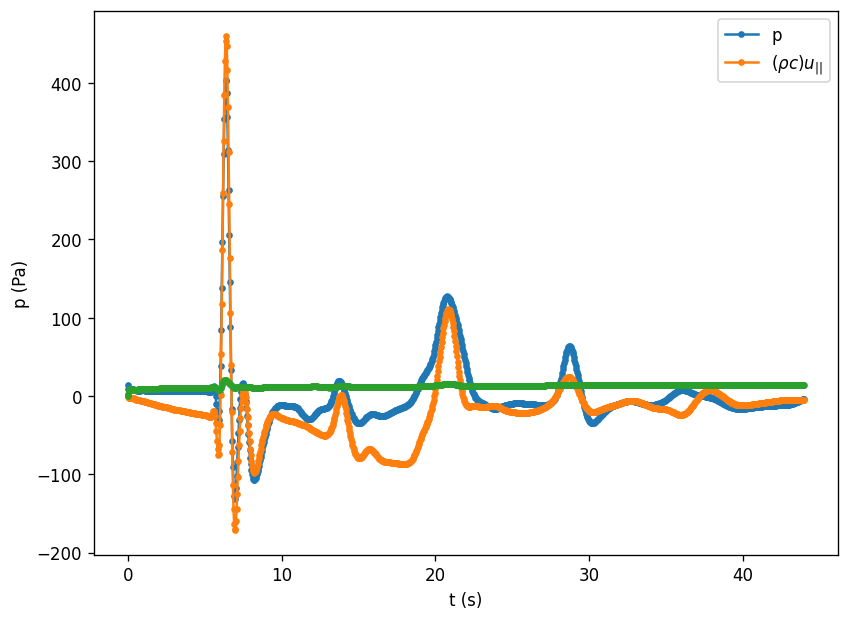

In [2082]:
rho = np.array([np.sum(state_coeffs[...,0:3],axis=-1) for state_coeffs in all_val]).squeeze()
sound_speed = compute_qty("SoundSpeed").squeeze()
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(t, p - np.mean(p), '.-')
plt.plot(t, rho * sound_speed * v_proj, '.-')
plt.plot(t, rho * sound_speed * v_orth, '.-')
plt.xlabel("t (s)")
plt.ylabel("p (Pa)")
plt.legend(["p", "$(\\rho c) u_{||}$"])

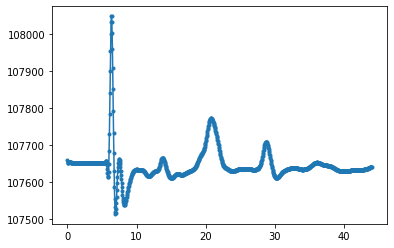

In [2088]:
plt.plot(t, p, '.-')

In [2083]:
# Compute |grad p|
def get_gradp(solver):
  sample_basis_phys_grad_elems = []
  sample_points_ref = solver.basis.PRINCIPAL_NODE_COORDS
  for elem_ID in range(solver.mesh.num_elems):
    solver.basis.get_basis_val_grads(
            sample_points_ref, # sample_points_in_domain[elem_ID,:,:],
            get_val=True,
            get_ref_grad=True,
            get_phys_grad=True,
            ijac=solver.elem_helpers.ijac_elems[elem_ID,0:sample_points_ref.shape[0],:,:])
    sample_basis_phys_grad_elems.append(solver.basis.basis_phys_grad)
  p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
  gradp = np.einsum('ijnl, ink -> ijkl',
      np.array(sample_basis_phys_grad_elems),
      p)
  normgradp = np.linalg.norm(
    gradp,
    axis=2, keepdims=True)
  return gradp, normgradp

In [2084]:
gradp, _ = get_gradp(solver2D_from(160,3))

In [489]:
f"{g:.2f}"

'9.80'

Text(0.5, 1.0, 'Time: 6.40 s')

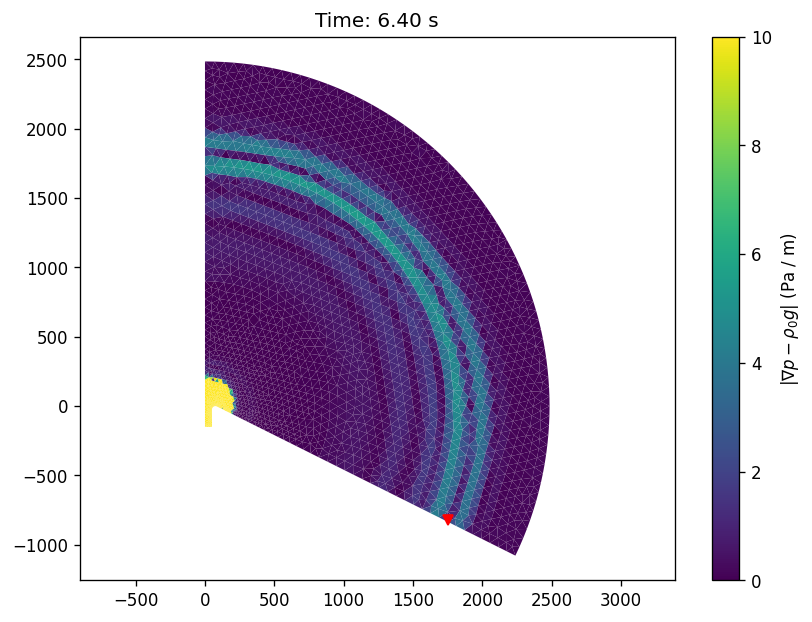

In [513]:
''' Show location of sensor on pressure gradient plot'''

plt.figure(figsize=(8, 6), dpi=120)

# Get initial (constant density)
rho0 = np.mean(solver2D_from(0,2).state_coeffs[...,0])
g = 9.8
hydrostatic_grad = rho0 * g

for j in [3]:
  x, p = mdtools.downsample(solver2D_from(160,j), plot_qty="Pressure")

  gradp, _ = get_gradp(solver2D_from(160,j))
  gradp[...,1] += hydrostatic_grad
  normgradp_reduced = np.linalg.norm(gradp, axis=-1)
  clims = (0,10)
  mdtools.plot_mean(x, normgradp_reduced, clims)
for j in [1,2]:
  x, p = mdtools.downsample(solver2D_from(16,j), plot_qty="Pressure")
  gradp, _ = get_gradp(solver2D_from(16,j))
  gradp[...,1] += hydrostatic_grad
  normgradp_reduced = np.linalg.norm(gradp, axis=-1)

  clims = (0,10)
  mdtools.plot_mean(x, normgradp_reduced, clims)

cb = plt.colorbar(plt.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
      cmap=plt.get_cmap()))
cb.set_label("$|\\nabla p - \\rho_0 g|$ (Pa / m)")

plt.plot(*sensor_loc, 'rv')
plt.title(f"Time: {solver2D_from(160,3).time:.2f} s")

In [518]:
outfilename = "tung3_pressuregrad_test_"
fig = plt.figure(figsize=(8, 6), dpi=120)
FFwriter = animation.FFMpegWriter()
FFwriter.setup(fig, f"{outfilename}.mp4")

# Get initial (constant density)
rho0 = np.mean(solver2D_from(0,2).state_coeffs[...,0])
g = 9.8
hydrostatic_grad = rho0 * g

for i in range(0,150,1):
  for j in [3]:
    x, p = mdtools.downsample(solver2D_from(10*i,j), plot_qty="Pressure")

    gradp, _ = get_gradp(solver2D_from(10*i,j))
    gradp[...,1] += hydrostatic_grad
    normgradp_reduced = np.linalg.norm(gradp, axis=-1)
    clims = (0,10)
    mdtools.plot_mean(x, normgradp_reduced, clims)
  for j in [2]:
    x, p = mdtools.downsample(solver2D_from(i,j), plot_qty="Pressure")
    gradp, _ = get_gradp(solver2D_from(i,j))
    gradp[...,1] += hydrostatic_grad
    normgradp_reduced = np.linalg.norm(gradp, axis=-1)

    clims = (0,10)
    mdtools.plot_mean(x, normgradp_reduced, clims)
  for j in [1]:
    x, p = mdtools.downsample(solver2D_from(5*i,j), plot_qty="Pressure")
    gradp, _ = get_gradp(solver2D_from(5*i,j))
    gradp[...,1] += hydrostatic_grad
    normgradp_reduced = np.linalg.norm(gradp, axis=-1)

    clims = (0,10)
    mdtools.plot_mean(x, normgradp_reduced, clims)

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("$|\\nabla p - \\rho_0 g|$ (Pa / m)")

  plt.plot(*sensor_loc, 'rv')
  plt.title(f"Time: {solver2D_from(10*i,3).time:.2f} s")
  FFwriter.grab_frame()
  plt.clf()

FFwriter.finish()

<Figure size 960x720 with 0 Axes>

In [520]:
plt.set_cmap("hot")

<Figure size 432x288 with 0 Axes>

In [528]:
solver2D_from(0,8)

FileNotFoundError: [Errno 2] No such file or directory: 'tung3_atm8_0.pkl'

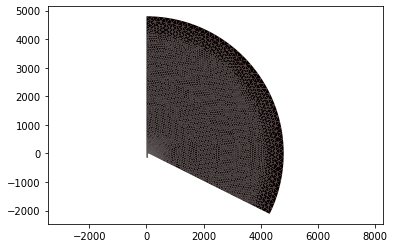

In [527]:
for j in [1,2,3,4,5,6,7]:
  x, blank = mdtools.downsample(solver2D_from(0,j), plot_qty="Temperature")
  blank*=0
  mdtools.plot_mean(x, blank, (0,0))

In [523]:
outfilename = "tung3_temperature_1"
fig = plt.figure(figsize=(8, 6), dpi=120)
FFwriter = animation.FFMpegWriter()
FFwriter.setup(fig, f"{outfilename}.mp4")

# Get initial (constant density)
rho0 = np.mean(solver2D_from(0,2).state_coeffs[...,0])
g = 9.8
hydrostatic_grad = rho0 * g
plt.set_cmap("hot")

for i in range(0,150,1):
  # for j in [3]:
  #   x, tmpr = mdtools.downsample(solver2D_from(10*i,j), plot_qty="Temperature")
  #   clims = (300,800)
  #   mdtools.plot_mean(x, tmpr, clims)
  # for j in [2]:
  #   x, tmpr = mdtools.downsample(solver2D_from(i,j), plot_qty="Temperature")
  #   clims = (300,1000)
  #   mdtools.plot_mean(x, tmpr, clims)
  for j in [1]:
    x, tmpr = mdtools.downsample(solver2D_from(5*i,j), plot_qty="Temperature")
    clims = (300,800)
    mdtools.plot_mean(x, tmpr, clims)

  cb = plt.colorbar(plt.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
        cmap=plt.get_cmap()))
  cb.set_label("$T$ (K)")

  # plt.plot(*sensor_loc, 'rv')
  plt.title(f"Time: {solver2D_from(10*i,3).time:.2f} s")
  FFwriter.grab_frame()
  plt.clf()

FFwriter.finish()

<Figure size 960x720 with 0 Axes>

In [565]:
x, phi = mdtools.downsample(solver1D_from(750,1), plot_qty="phi")
phi = np.mean(phi,axis=1).squeeze()
x = np.mean(x,axis=1).squeeze()

In [574]:
np.argmax(phi > phi_crit)

87

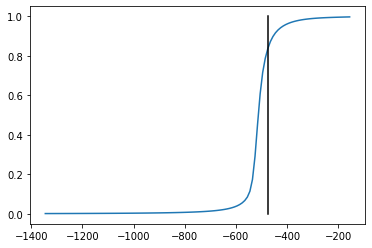

In [576]:
phi_crit = solver1D_from(0,1).physics.source_terms[1].crit_volfrac
plt.plot(x, phi)
plt.plot(x[np.argmax(phi > phi_crit)]*np.array([1,1]), np.array([0,1]), 'k-')

In [585]:
outfilename = "tung3_conduit_frag"
fig = plt.figure(figsize=(8, 6), dpi=120)
FFwriter = animation.FFMpegWriter(fps=15)
FFwriter.setup(fig, f"{outfilename}.mp4")

# Get initial (constant density)
rho0 = np.mean(solver1D_from(0,1).state_coeffs[...,0])
# g = 9.8
# hydrostatic_grad = rho0 * g
# plt.set_cmap("hot")
phi_crit = solver1D_from(0,1).physics.source_terms[1].crit_volfrac

for i in range(0,150,1):
  # for j in [3]:
  #   x, tmpr = mdtools.downsample(solver2D_from(10*i,j), plot_qty="Temperature")
  #   clims = (300,800)
  #   mdtools.plot_mean(x, tmpr, clims)
  # for j in [2]:
  #   x, tmpr = mdtools.downsample(solver2D_from(i,j), plot_qty="Temperature")
  #   clims = (300,1000)
  #   mdtools.plot_mean(x, tmpr, clims)
  for j in [1,2]:
    if j == 1:
      x, phi = mdtools.downsample(solver1D_from(5*i,j), plot_qty="phi")
    elif j == 2:
      x, phi = mdtools.downsample(solver1D_from(i,j), plot_qty="phi")
    phi = np.mean(phi,axis=1).squeeze()
    x = np.mean(x,axis=1).squeeze()
    plt.plot(x, phi)
    plt.plot(x[np.argmax(phi > phi_crit)]*np.array([1,1]), np.array([0,1]), 'k-')

  plt.xlabel("z (m)")
  plt.ylabel("Gas volume fraction")
  plt.title(f"Time: {solver1D_from(i,2).time:.2f} s")
  FFwriter.grab_frame()
  plt.clf()

FFwriter.finish()

<Figure size 960x720 with 0 Axes>

In [584]:
''' 1D pressure '''
outfilename = "tung3_conduit_p_"
fig = plt.figure(figsize=(8, 6), dpi=120)
FFwriter = animation.FFMpegWriter(fps=15)
FFwriter.setup(fig, f"{outfilename}.mp4")

# Get initial (constant density)
rho0 = np.mean(solver1D_from(0,1).state_coeffs[...,0])
# g = 9.8
# hydrostatic_grad = rho0 * g
# plt.set_cmap("hot")
phi_crit = solver1D_from(0,1).physics.source_terms[1].crit_volfrac

for i in range(0,150,1):
  # for j in [3]:
  #   x, tmpr = mdtools.downsample(solver2D_from(10*i,j), plot_qty="Temperature")
  #   clims = (300,800)
  #   mdtools.plot_mean(x, tmpr, clims)
  # for j in [2]:
  #   x, tmpr = mdtools.downsample(solver2D_from(i,j), plot_qty="Temperature")
  #   clims = (300,1000)
  #   mdtools.plot_mean(x, tmpr, clims)
  for j in [1,2]:
    if j == 1:
      x, p = mdtools.downsample(solver1D_from(5*i,j), plot_qty="Pressure")
    elif j == 2:
      x, p = mdtools.downsample(solver1D_from(i,j), plot_qty="Pressure")
    p = np.mean(p,axis=1).squeeze()
    x = np.mean(x,axis=1).squeeze()
    plt.plot(x, p)

  plt.xlabel("z (m)")
  plt.ylabel("Pressure")
  plt.ylim((0,2.5e8))
  plt.title(f"Time: {solver1D_from(i,2).time:.2f} s")
  FFwriter.grab_frame()
  plt.clf()

FFwriter.finish()

<Figure size 960x720 with 0 Axes>

In [589]:
''' 1D velocity '''
outfilename = "tung3_conduit_M_"
fig = plt.figure(figsize=(8, 6), dpi=120)
FFwriter = animation.FFMpegWriter(fps=5)
FFwriter.setup(fig, f"{outfilename}.mp4")

# Get initial (constant density)
rho0 = np.mean(solver1D_from(0,1).state_coeffs[...,0])
# g = 9.8
# hydrostatic_grad = rho0 * g
# plt.set_cmap("hot")
phi_crit = solver1D_from(0,1).physics.source_terms[1].crit_volfrac

for i in range(0,150,1):
  # for j in [3]:
  #   x, tmpr = mdtools.downsample(solver2D_from(10*i,j), plot_qty="Temperature")
  #   clims = (300,800)
  #   mdtools.plot_mean(x, tmpr, clims)
  # for j in [2]:
  #   x, tmpr = mdtools.downsample(solver2D_from(i,j), plot_qty="Temperature")
  #   clims = (300,1000)
  #   mdtools.plot_mean(x, tmpr, clims)
  for j in [1,2]:
    if j == 1:
      x, u = mdtools.downsample(solver1D_from(5*i,j), plot_qty="XVelocity")
      _, c = mdtools.downsample(solver1D_from(5*i,j), plot_qty="SoundSpeed")
    elif j == 2:
      x, u = mdtools.downsample(solver1D_from(i,j), plot_qty="XVelocity")
      _, c = mdtools.downsample(solver1D_from(i,j), plot_qty="SoundSpeed")
    M = np.mean(u/c,axis=1).squeeze()
    x = np.mean(x,axis=1).squeeze()
    plt.plot(x, M)

  plt.xlabel("z (m)")
  plt.ylabel("u / c")
  plt.ylim((-2,2))
  plt.title(f"Time: {solver1D_from(i,2).time:.2f} s")
  FFwriter.grab_frame()
  plt.clf()

FFwriter.finish()

<Figure size 960x720 with 0 Axes>

Text(0.5, 0, 'Time (s)')

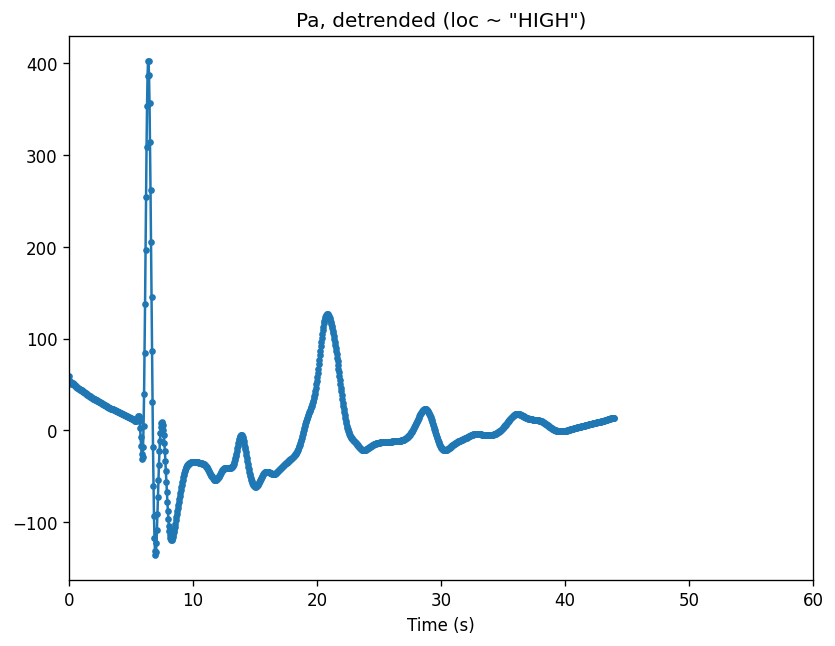

In [423]:
import scipy.signal
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(t, scipy.signal.detrend(p), '.-')
plt.title('Pa, detrended (loc ~ "HIGH")')
plt.xlim(0, 60)
plt.xlabel('Time (s)')

--------------------------------------------------------

Text(0, 0.5, 'rho u')

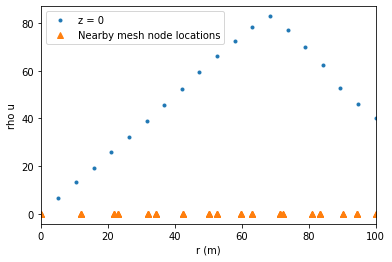

In [125]:
# Plot momentum along arbitrary probe line
xline = np.array([np.linspace(0, 100, 20), np.linspace(0, 0, 20)]).transpose()

solver = solver2D_from(i,1)
# rhou = plot.get_numerical_solution(solver.physics, solver.state_coeffs, xline,
					# solver.basis, "XMomentum"
solver.order, temp = 0, solver.order
xsoln = plot.get_sample_points(solver.mesh, solver, solver.physics, solver.basis, True)
solver.order = temp

var = plot.get_numerical_solution(solver.physics, solver.state_coeffs, xsoln,
	solver.basis, 'XMomentum')
rhou = plot.interpolate_2D_soln_to_points(solver.physics, xsoln, var, xline)

plt.plot(xline[:,0], rhou, '.')

# Filter nearby mesh nodes
mesh_x_vec = x1.reshape(-1, x1.shape[-1])
mesh_x_vec_near = np.array([pt[0] for pt in zip(mesh_x_vec) if np.abs(pt[0][1] - 0) < 10])
plt.plot(mesh_x_vec_near[:,0], 0*mesh_x_vec_near[:,0],'^')
plt.xlim((0,100))
plt.legend(["z = 0", "Nearby mesh node locations"])
plt.xlabel("r (m)")
plt.ylabel("rho u")

In [137]:
solver.physics.Gas[0]

{'R': 287.0, 'gamma': 1.4, 'c_v': 717.5000000000001, 'c_p': 1004.5000000000001}

In [127]:
%matplotlib tk
''' Animation for velocity component'''

from matplotlib.animation import FuncAnimation
# mdtools.viz(solver2D_from(0))
# clims = (-0.1e5, 0.1e5)
clims = (-10, 100)
_, v0 = mdtools.downsample(solver2D_from(0,1), plot_qty="XVelocity")

def animate(i):
  plt.clf()
  solver = solver2D_from(i,1)
  x, v = mdtools.downsample(solver, plot_qty="XVelocity")
  mdtools.plot_mean(x, v, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  plt.title(f"t = {solver.time}")

anim = FuncAnimation(plt.figure(), animate, frames=range(5,200,1), interval=1,
  repeat=True)
plt.show()

In [135]:
mdtools.generate_anim(["mixture_shocktube_atm1_cyl", "mixture_shocktube_atm2_cyl"], ["mixture_shocktube_conduit_cyl"], "cyl_test_p_all", 25,
  "Pressure", initial=1, stride=5, is_high_detail=False)
mdtools.generate_anim(["mixture_shocktube_atm1_cyl", "mixture_shocktube_atm2_cyl"], [], "cyl_test_r_velocity", 25,
  "XVelocity", initial=1, stride=5, is_high_detail=False)

Animation constructed
Animation constructed


------------------

----------

In [162]:
%matplotlib tk
''' Animation for log10(abs(delta p))'''

from matplotlib.animation import FuncAnimation
# mdtools.viz(solver2D_from(0))
# clims = (-0.1e5, 0.1e5)
clims = (0, 6)
_, p0 = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")

def animate(i):
  plt.clf()
  x, p = mdtools.downsample(solver2D_from(i), plot_qty="Pressure")
  mdtools.plot_mean(x, np.log10(np.abs(p-p0)), clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)

anim = FuncAnimation(plt.figure(), animate, frames=range(1,200,5), interval=1,
  repeat=True)
plt.show()

C:\Users\Fredric\AppData\Local\Temp\ipykernel_86072\2456651837.py:12: RuntimeWarning: divide by zero encountered in log10
  mdtools.plot_mean(x, np.log10(np.abs(p-p0)), clims)
